In [1]:
import random
import pennylane as qml
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import copy
from sklearn.metrics import roc_auc_score
import copy
import time
from typing import Any, Optional, Tuple, Callable
import mne
from sklearn.model_selection import train_test_split
import math

print('Pennylane Version :', qml.__version__)
print('Pytorch Version :', torch.__version__)

/tmp/ipykernel_1358045/3533676007.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Pennylane Version : 0.41.0
Pytorch Version : 2.2.0+cu121


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Running on ", device)

Running on  cuda


In [3]:
def set_all_seeds(seed: int = 42) -> None:
    """Seed every RNG we rely on (Python, NumPy, Torch, PennyLane, CUDNN)."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)           # no-op on CPU
    torch.backends.cudnn.deterministic = True  # reproducible convolutions
    torch.backends.cudnn.benchmark = False
    os.environ["PL_GLOBAL_SEED"] = str(seed) 

# QCNN

In [4]:
class QCNN(nn.Module):
    def __init__(self, n_qubits=8, n_layers=2, input_dim=784, num_classes=10):
        """
        QCNN with classical dimensionality reduction and variational embedding for multi-class classification.

        Args:
            n_qubits (int): Number of qubits.
            n_layers (int): Number of convolutional & pooling layers.
            input_dim (int): Original input data dimensionality (e.g., MNIST image size).
            num_classes (int): Number of classes for classification.
        """
        super(QCNN, self).__init__()

        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.num_classes = num_classes

        print(f"input_dim: {input_dim}")

        # Classical dimension reduction (fully-connected layer)
        self.fc = nn.Linear(input_dim, n_qubits)
        
        # Quantum parameters
        self.conv_params = nn.Parameter(torch.randn(n_layers, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(n_layers, n_qubits // 2, 3))

        # Quantum device initialization
        self.dev = qml.device("default.qubit", wires=n_qubits)

    def circuit(self, conv_weights, pool_weights, features):
        wires = list(range(self.n_qubits))

        # Variational Embedding (Angle Embedding)
        qml.AngleEmbedding(features, wires=wires, rotation='Y')

        for layer in range(self.n_layers):
            # Convolutional Layer
            self._apply_convolution(conv_weights[layer], wires)
            # Pooling Layer
            self._apply_pooling(pool_weights[layer], wires)
            wires = wires[::2]  # Retain every second qubit after pooling
            
        # Measurement: A single PauliZ to measure the state of the first qubit for binary classification
        return qml.expval(qml.PauliZ(self.n_qubits-1))

    def forward(self, x):
        # Classical dimension reduction
        reduced_x = self.fc(x)

        print(f"reduced_x shape: {reduced_x.shape}")

        # Quantum Circuit Execution
        quantum_out = qml.qnode(self.dev, interface="torch")(self.circuit)(self.conv_params, self.pool_params, reduced_x)
        # Convert quantum output to logits for multi-class classification
        quantum_out = torch.stack(quantum_out, dim=1).float()
        return quantum_out

    def _apply_convolution(self, weights, wires):
        """
        Convolutional layer logic (same as original).
        """
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        # Pooling using a variational circuit
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

## Circuit Visualization

In [5]:
n_qubits = 8
n_layers = 2
classical_features = np.random.rand(8)

In [6]:
# Quantum parameters
conv_params = nn.Parameter(torch.randn(n_layers, n_qubits, 15))
pool_params = nn.Parameter(torch.randn(n_layers, n_qubits // 2, 3))

# Quantum device initialization
dev = qml.device("default.qubit", wires=n_qubits)

def circuit(conv_weights, pool_weights, features):
    wires = list(range(n_qubits))
    # Variational Embedding (Angle Embedding)
    qml.AngleEmbedding(features, wires=wires, rotation='Y')
    for layer in range(n_layers):
        # Convolutional Layer
        _apply_convolution(conv_weights[layer], wires)
        # Pooling Layer
        _apply_pooling(pool_weights[layer], wires)
        wires = wires[::2]  # Retain every second qubit after pooling
    # Measurement: A single PauliZ to measure the state of the first qubit for binary classification
    return qml.expval(qml.PauliZ(n_qubits-1))

def _apply_convolution(weights, wires):
    """
    Convolutional layer logic (same as original).
    """
    n_wires = len(wires)
    for p in [0, 1]:
        for indx, w in enumerate(wires):
            if indx % 2 == p and indx < n_wires - 1:
                qml.U3(*weights[indx, :3], wires=w)
                qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                qml.U3(*weights[indx, 9:12], wires=w)
                qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

def _apply_pooling(pool_weights, wires):
    # Pooling using a variational circuit
    n_wires = len(wires)
    assert n_wires >= 2, "Need at least two wires for pooling."
    for indx, w in enumerate(wires):
        if indx % 2 == 1 and indx < n_wires:
            measurement = qml.measure(w)
            qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

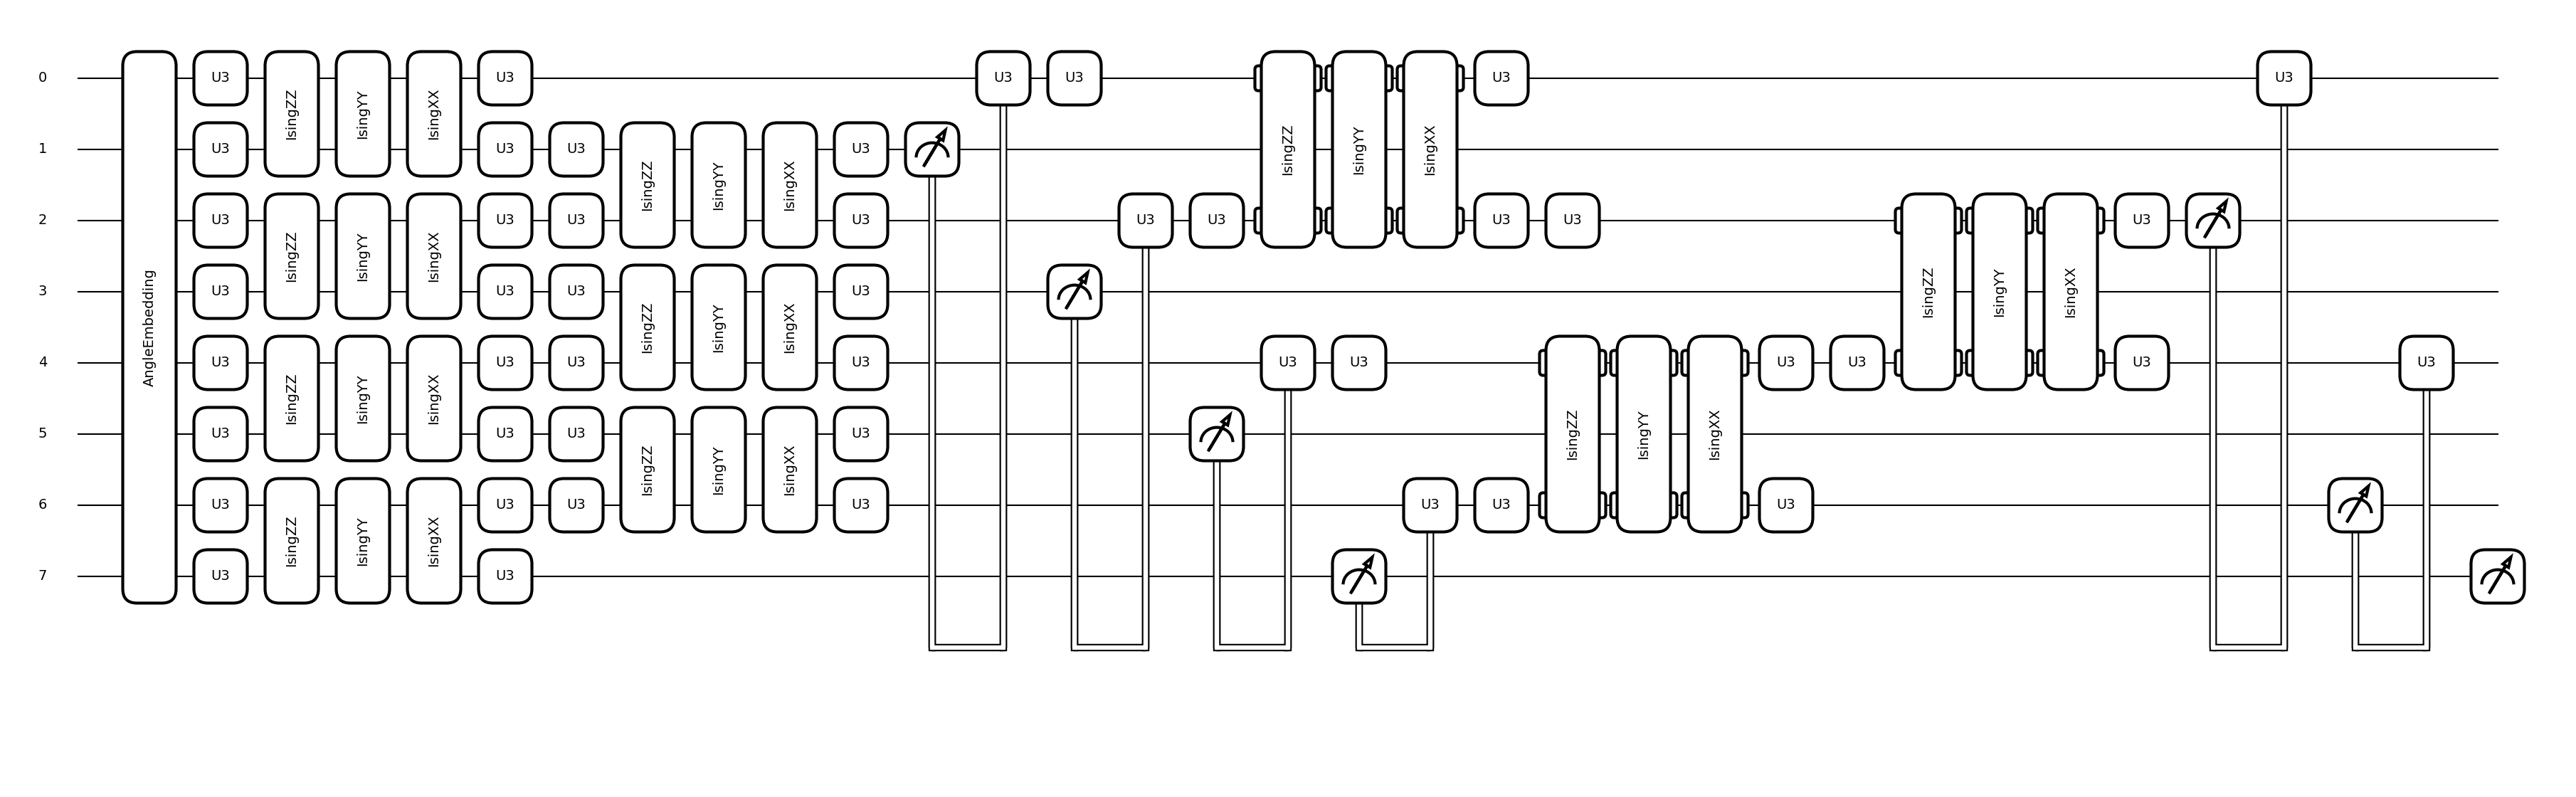

In [7]:
fig, ax = qml.draw_mpl(circuit)(conv_params, pool_params, classical_features)

# QTCN 1: QCNN + (Classical Dilation, Causal, Residual)

In [14]:
class QTCN(nn.Module):
    def __init__(self, n_qubits, circuit_depth, input_dim, kernel_size, dilation=1):
        super(QTCN, self).__init__()
        self.n_qubits = n_qubits
        self.circuit_depth = circuit_depth
        
        # Quantum parameters
        self.conv_params = nn.Parameter(torch.randn(circuit_depth, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))
        
        # Quantum device initialization
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        # The kernel size defines how many time steps we consider for the "convolution"
        self.input_channels = input_dim[1]
        self.time_steps = input_dim[2]
        self.kernel_size = kernel_size
        self.dilation = dilation
        
        # The input channels are treated as the feature size for each time step
        # Fully connected classical linear layer
        self.fc = nn.Linear(self.input_channels * self.kernel_size, n_qubits)  # For dimension reduction
        self.downsample = nn.Linear(self.input_channels * self.kernel_size, n_qubits)
        # self.fc_out = nn.Linear(self.time_steps - self.dilation * (self.kernel_size - 1), 1)  # Final output layer for Binary Classification

    def circuit(self, features):
        wires = list(range(self.n_qubits))    
        # Variational Embedding (Angle Embedding)
        qml.AngleEmbedding(features, wires=wires, rotation='Y')
        for layer in range(self.circuit_depth):
            # Convolutional Layer
            self._apply_convolution(self.conv_params[layer], wires)
            # Pooling Layer
            self._apply_pooling(self.pool_params[layer], wires)
            wires = wires[::2]  # Retain every second qubit after pooling
        # Measurement
        return qml.expval(qml.PauliZ(self.n_qubits-1))

    def _apply_convolution(self, weights, wires):
        """
        Convolutional layer logic (same as original).
        """
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        # Pooling using a variational circuit
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."

        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])
                
    def forward(self, x):
        # x has shape (batch_size, time_steps, input_channels)
        batch_size, input_channels, time_steps = x.size()
        # Quantum Circuit Execution
        quantum_circuit = qml.QNode(self.circuit, self.dev)
        # Initialize an empty list to store the output
        output = []
        # Slide a window of size `kernel_size` across the time steps (with dilation)
        for i in range(self.dilation * (self.kernel_size - 1), time_steps):
            indices = [i - d*self.dilation for d in range(self.kernel_size)]
            indices.reverse()
            window = x[:, :, indices].reshape(batch_size, -1)
            reduced_window = self.fc(window)
            residual = x[:, :, -(self.kernel_size):].reshape(batch_size, -1)
            residual = self.downsample(residual)
            output.append(quantum_circuit(reduced_window+residual))
        # output = torch.stack(output, dim=1)
        # output = self.fc_out(output.float()).squeeze(1)
        output = torch.mean(torch.stack(output, dim=1), dim=1)
        return output

# QTCN 2: (QCNN+Quantum Dilation) + (Classical Causal, Residual)

In [9]:
class QTCN2(nn.Module):
    """
    Quantum Temporal Convolutional Network (QTCN) using a QCNN-style ansatz.

    This model processes spatio-temporal data by:
    1. Using a classical Conv1D layer for feature extraction.
    2. Processing a sliding window of data (receptive field) on a quantum circuit.
    3. Applying causal, dilated convolutions using a complex U3/Ising gate structure.
    4. Using a "conveyor belt" mechanism to stream through the time-series data.

    Args:
        input_channels (int): Number of features for each time step in the input data.
        receptive_field_size (int): The number of time steps the quantum circuit processes. This equals the number of qubits.
        n_layers (int): The number of stacked dilated convolutional layers.
    """

    def __init__(self, receptive_field_size=8, n_layers=3,  input_channels=64):
        super(QTCN2, self).__init__()

        if 2**(n_layers-1) > receptive_field_size:
            raise ValueError("The largest dilation factor (2**(n_layers-1)) cannot exceed the receptive field size.")

        self.receptive_field_size = receptive_field_size
        self.n_layers = n_layers
        self.input_channels = input_channels

        # 1. Classical Feature Extraction
        # This layer reduces the multiple input channels at each time step to a single feature.
        # This single feature will then be encoded into a qubit's angle.        
        self.feature_extractor = nn.Conv1d(
            in_channels=self.input_channels,
            out_channels=1,
            kernel_size=1
        )

        # 2. Quantum Parameters (MODIFIED)
        # Each layer now has a set of 15 shared parameters for the complex QCNN ansatz.
        self.conv_params = nn.Parameter(torch.randn(n_layers, 15))

        # 3. Quantum Device and QNode (Unchanged)
        self.dev = qml.device("default.qubit", wires=self.receptive_field_size)
        self.qnode = qml.QNode(self._circuit, self.dev, interface="torch")

        # self.fc_out = nn.Linear(self.time_steps - self.dilation * (self.kernel_size - 1), 1)  # Final output layer for Binary Classification
        
    def _apply_dilated_conv(self, weights, dilation):
        """
        Applies a single layer of causal, dilated convolution using the QCNN ansatz.

        Args:
            weights (torch.Tensor): The learnable parameters for this layer, shape (15,).
            dilation (int): The dilation factor (d).
        """
        # The 15 parameters are shared across all pairs in this layer,
        # achieving the "weight sharing" of a classical convolution.
        for i in range(self.receptive_field_size - dilation):
            # Define the pair of qubits for the dilated interaction
            w1 = i
            w2 = i + dilation

            # Apply the sequence of gates from the QCNN ansatz
            qml.U3(*weights[:3], wires=w1)
            qml.U3(*weights[3:6], wires=w2)
            qml.IsingZZ(weights[6], wires=[w1, w2])
            qml.IsingYY(weights[7], wires=[w1, w2])
            qml.IsingXX(weights[8], wires=[w1, w2])
            qml.U3(*weights[9:12], wires=w1)
            qml.U3(*weights[12:15], wires=w2)

    def _circuit(self, features, conv_params):
        """
        The quantum circuit. The logic is the same, but it calls the new conv layer.

        Args:
            features (torch.Tensor): A tensor of size (receptive_field_size,).
            conv_params (torch.Tensor): The learnable parameters for all layers.
        """
        qml.AngleEmbedding(features, wires=range(self.receptive_field_size), rotation='Y')

        # Stack layers with exponentially growing dilations
        for layer_idx in range(self.n_layers):
            dilation = 2**layer_idx
            # Pass the correct set of 15 parameters for the current layer
            self._apply_dilated_conv(conv_params[layer_idx], dilation)

        return qml.expval(qml.PauliZ(self.receptive_field_size - 1))

    def forward(self, x):
        """
        The main forward pass implementing the "Conveyor Belt" (Unchanged).

        Args:
            x (torch.Tensor): Input data of shape (batch_size, input_channels, time_steps).
        Returns:
            torch.Tensor: A tensor of predictions, shape (batch_size, num_predictions).
        """
        batch_size = x.shape[0]
        time_steps = x.shape[2]

        if time_steps < self.receptive_field_size:
            raise ValueError(f"Input time steps ({time_steps}) must be at least as large as the receptive field ({self.receptive_field_size}).")

        x = self.feature_extractor(x)
        x = x.squeeze(1)

        batch_predictions = []
        for i in range(batch_size):
            sample_sequence = x[i]
            window = sample_sequence[:self.receptive_field_size].clone()
            sequence_predictions = []

            for t in range(time_steps - self.receptive_field_size + 1):
                q_out = self.qnode(window, self.conv_params)
                sequence_predictions.append(q_out)
                
                if t < time_steps - self.receptive_field_size:
                    window = torch.roll(window, shifts=-1, dims=0)
                    window[-1] = sample_sequence[t + self.receptive_field_size]

            batch_predictions.append(torch.stack(sequence_predictions))
        outputs = torch.mean(torch.stack(batch_predictions), dim=1)

        return outputs

## Circuit Visualization

In [10]:
n_qubits = 8
n_layers = 2
classical_features = np.random.rand(8)
conv_params = nn.Parameter(torch.randn(n_layers, 15))

In [11]:
def _apply_dilated_conv(weights, dilation):
    """
    Applies a single layer of causal, dilated convolution using the QCNN ansatz.

    Args:
        weights (torch.Tensor): The learnable parameters for this layer, shape (15,).
        dilation (int): The dilation factor (d).
    """
    # The 15 parameters are shared across all pairs in this layer,
    # achieving the "weight sharing" of a classical convolution.
    for i in range(n_qubits - dilation):
        # Define the pair of qubits for the dilated interaction
        w1 = i
        w2 = i + dilation

        # Apply the sequence of gates from the QCNN ansatz
        qml.U3(*weights[:3], wires=w1)
        qml.U3(*weights[3:6], wires=w2)
        qml.IsingZZ(weights[6], wires=[w1, w2])
        qml.IsingYY(weights[7], wires=[w1, w2])
        qml.IsingXX(weights[8], wires=[w1, w2])
        qml.U3(*weights[9:12], wires=w1)
        qml.U3(*weights[12:15], wires=w2)

def _circuit(features, conv_params):
    """
    The quantum circuit. The logic is the same, but it calls the new conv layer.
    
    Args:
        features (torch.Tensor): A tensor of size (receptive_field_size,).
        conv_params (torch.Tensor): The learnable parameters for all layers.
    """
    qml.AngleEmbedding(features, wires=range(n_qubits), rotation='Y')
    # Stack layers with exponentially growing dilations
    for layer_idx in range(n_layers):
        dilation = 2**layer_idx
        # Pass the correct set of 15 parameters for the current layer
        _apply_dilated_conv(conv_params[layer_idx], dilation)

    return qml.expval(qml.PauliZ(n_qubits - 1))

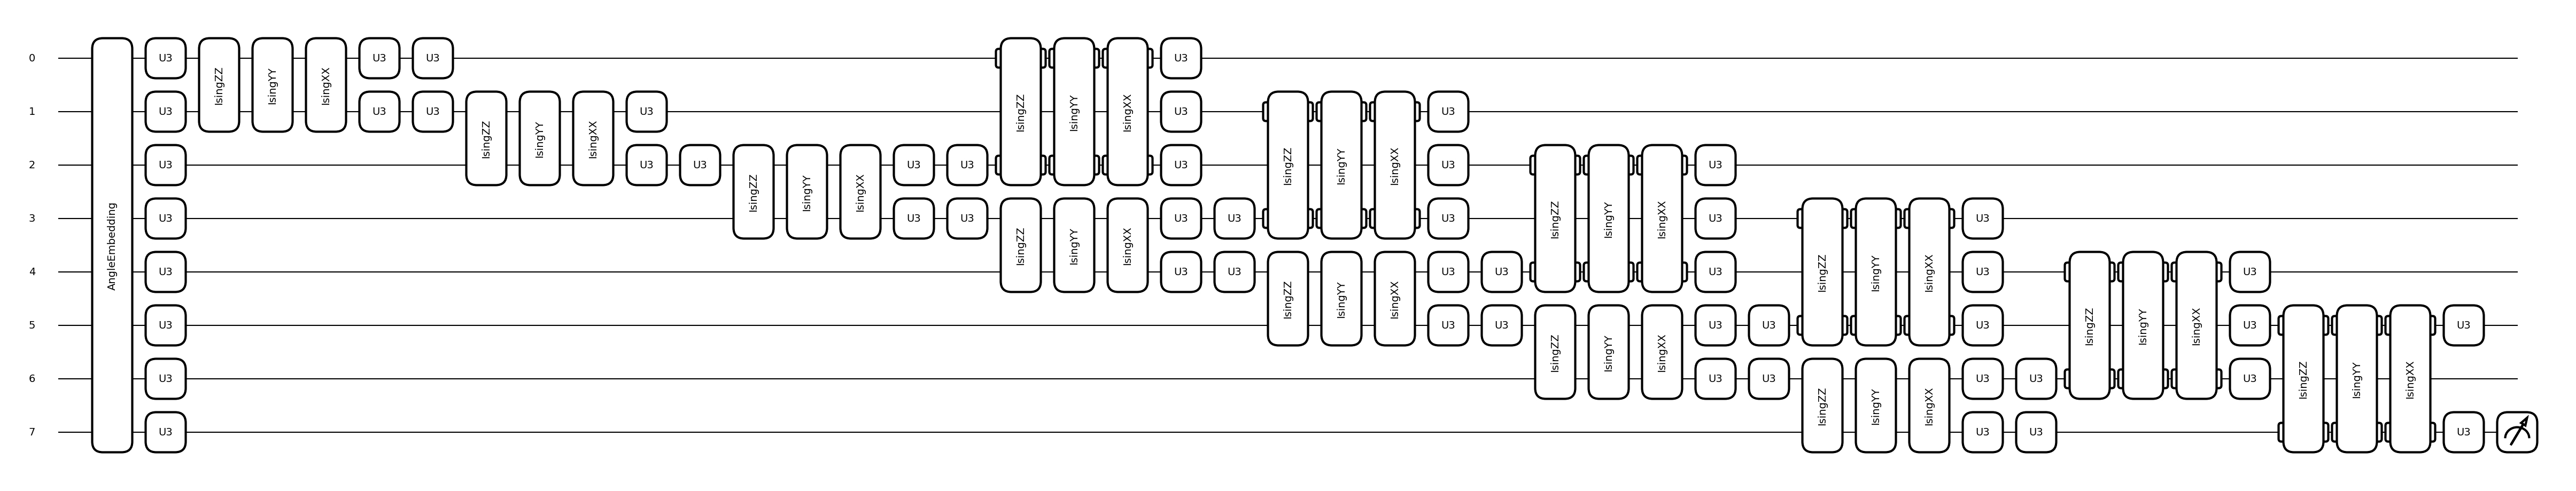

In [12]:
fig, ax = qml.draw_mpl(_circuit)(classical_features, conv_params)

## ChatGPT Version

In [13]:
# -------------------------------------------------------------
# 1.  Imports
# -------------------------------------------------------------
import torch
import torch.nn as nn
import pennylane as qml
import math

# -------------------------------------------------------------
# 2.  Helper: one causal‑dilated layer (kernel size k = 2)
# -------------------------------------------------------------
def qcnn_dilated_layer(wires, theta15, dilation):
    """
    QCNN 15‑parameter kernel applied to every non‑overlapping pair
    (q_i, q_{i+dilation}) where i starts at parity p.
    The pattern mirrors your original _apply_convolution.
    """
    n = len(wires)

    # run two passes, parity p = 0 then p = 1, so that no qubit
    # participates twice in the same pass
    for p in [0, 1]:
        for i in range(n - dilation):
            # pick non‑overlapping pairs
            if (i % (2 * dilation) == p) and (i + dilation < n):
                qL, qR = wires[i], wires[i + dilation]

                # ----  QCNN kernel  ---------------------------------
                qml.U3(*theta15[0:3],  wires=qL)
                qml.U3(*theta15[3:6],  wires=qR)

                qml.IsingZZ(theta15[6],  wires=[qL, qR])
                qml.IsingYY(theta15[7],  wires=[qL, qR])
                qml.IsingXX(theta15[8],  wires=[qL, qR])

                qml.U3(*theta15[9:12],  wires=qL)
                qml.U3(*theta15[12:15], wires=qR)
                # -----------------------------------------------------

# -------------------------------------------------------------
# 3.  QTCN module
# -------------------------------------------------------------
class QTCN_GPT(nn.Module):
    """
    Quantum Temporal Convolutional Network with
    - dilated skip‑entangler convolutions
    - conveyor‑belt SWAP shift for strict causality
    """

    def __init__(
        self,
        n_qubits        : int   = 8,          # window length  R
        n_layers        : int   = 3,          # number of dilated conv layers
        dilations       : tuple = (1, 2, 4),  # can be customised
        in_channels     : int   = 64,         # EEG channels, for example
        time_steps      : int   = 128,        # full sequence length  T
        n_outputs       : int   = 1           # binary classification
    ):
        super().__init__()
        assert len(dilations) == n_layers, "dilations list must match n_layers"
        assert max(dilations) < n_qubits,     "dilation cannot exceed register"

        self.R          = n_qubits
        self.T          = time_steps
        self.dilations  = dilations
        self.n_layers   = n_layers
        self.n_outputs  = n_outputs

        # --- classical pre‑processing ---
        # Compress the C (channel) dimension down to one scalar per time‑step
        self.channel_reducer = nn.Linear(in_channels, 1)

        # --- shared quantum weights: one θ per layer (k = 2 kernel) ---
        #   If you prefer >1 parameter per layer, change causal_dilated_layer.
        self.theta = nn.Parameter(torch.randn(n_layers, 15) * 0.01)

        # PennyLane device
        self.dev = qml.device("default.qubit", wires=self.R)

        # Register the QNode once with Torch interface
        self.QNode = qml.QNode(self._circuit, self.dev)

    # ---------------------------------------------------------
    # 3.1  Quantum circuit   (one *entire* sequence per call)
    # ---------------------------------------------------------
    def _circuit(self, time_series, thetas):
        """
        Parameters
        ----------
        time_series : 1‑D Tensor of length T (already channel‑reduced)
        thetas      : 1‑D Tensor of length n_layers (trainable)
        """
        wires = list(range(self.R))

        # -------------------------------------------------
        # Step‑0  :  encode the *first R* samples
        # -------------------------------------------------
        qml.AngleEmbedding(time_series[0 : self.R], wires=wires, rotation="Y")

        # Convenience: pointer to the next sample to be ingested
        next_ptr = self.R

        # A list to collect logits per time‑step (optional)
        outputs = []

        # -------------------------------------------------
        # Step loop : stream through the remaining samples
        # -------------------------------------------------
        for t in range(self.R - 1, self.T):        # t indexes "current" time
            # (1) apply L dilated causal layers
            for l, d in enumerate(self.dilations):
                qcnn_dilated_layer(wires, thetas[l], dilation=d)

            # # (2) shift register & load next sample *unless* we're at last step
            # if t < self.T - 1:
            #     for q in range(self.R - 1):
            #         qml.SWAP(wires=[wires[q], wires[q + 1]])
            #     qml.RY(time_series[next_ptr] * 2 * math.pi, wires=wires[-1])
            #     next_ptr += 1

        # single measurement at the very end
        return qml.expval(qml.PauliZ(wires[-1]))                      # expval ∈ [‑1, +1]

    # ---------------------------------------------------------
    # 3.2  Forward pass  (batch × channels × time)
    # ---------------------------------------------------------
    def forward(self, x):
        """
        x shape: (batch, channels, time_steps)
        """
        B, C, T = x.shape
        assert T == self.T, "Sequence length must match time_steps"

        # (i) channel reduction  (vectorised: B × T × 1)
        #     Permute so Linear sees the channel dim last.
        x_reduced = self.channel_reducer(x.permute(0, 2, 1)).squeeze(-1)

        # (ii) run the quantum circuit *sample‑by‑sample* (batch loop)
        logits = []
        for b in range(B):
            logits.append(self.QNode(x_reduced[b], self.theta))

        logits = torch.stack(logits)          # shape (B,)
        # Map ⟨Z⟩ ∈ [‑1,1] to logit:   logit = α·⟨Z⟩ + β   (learnable if desired)
        return logits           

In [14]:
R = 8
T = 10
n_layers = 3
classical_features = np.random.rand(12)
# --- shared quantum weights: one θ per layer (k = 2 kernel) ---
#   If you prefer >1 parameter per layer, change causal_dilated_layer.
theta = nn.Parameter(torch.randn(n_layers, 15) * 0.01)
dilations = (1, 2)

In [15]:
# -------------------------------------------------------------
# 2.  Helper: one causal‑dilated layer (kernel size k = 2)
# -------------------------------------------------------------
def qcnn_dilated_layer(wires, theta15, dilation):
    """
    QCNN 15‑parameter kernel applied to every non‑overlapping pair
    (q_i, q_{i+dilation}) where i starts at parity p.
    The pattern mirrors your original _apply_convolution.
    """
    n = len(wires)

    # run two passes, parity p = 0 then p = 1, so that no qubit
    # participates twice in the same pass
    for p in [0, 1]:
        for i in range(n - dilation):
            # pick non‑overlapping pairs
            if (i % (2 * dilation) == p) and (i + dilation < n):
                qL, qR = wires[i], wires[i + dilation]

                # ----  QCNN kernel  ---------------------------------
                qml.U3(*theta15[0:3],  wires=qL)
                qml.U3(*theta15[3:6],  wires=qR)

                qml.IsingZZ(theta15[6],  wires=[qL, qR])
                qml.IsingYY(theta15[7],  wires=[qL, qR])
                qml.IsingXX(theta15[8],  wires=[qL, qR])

                qml.U3(*theta15[9:12],  wires=qL)
                qml.U3(*theta15[12:15], wires=qR)
                # -----------------------------------------------------
                
# ---------------------------------------------------------
# 3.1  Quantum circuit   (one *entire* sequence per call)
# ---------------------------------------------------------
def _circuit(time_series, thetas):
    """
    Parameters
    ----------
    time_series : 1‑D Tensor of length T (already channel‑reduced)
    thetas      : 1‑D Tensor of length n_layers (trainable)
    """
    wires = list(range(R))
    # -------------------------------------------------
    # Step‑0  :  encode the *first R* samples
    # -------------------------------------------------
    qml.AngleEmbedding(time_series[0 : R], wires=wires, rotation="Y")

    # Convenience: pointer to the next sample to be ingested
    next_ptr = R
    # A list to collect logits per time‑step (optional)
    outputs = []

    # -------------------------------------------------
    # Step loop : stream through the remaining samples
    # -------------------------------------------------
    for t in range(R - 1, T):        # t indexes "current" time
        # (1) apply L dilated causal layers
        for l, d in enumerate(dilations):
            qcnn_dilated_layer(wires, thetas[l], dilation=d)

       # (2) shift register & load next sample *unless* we're at last step
        if t < T - 1:
            for q in range(R - 1):
                qml.SWAP(wires=[wires[q], wires[q + 1]])
            qml.RY(time_series[next_ptr] * 2 * math.pi, wires=wires[-1])
            next_ptr += 1

    # single measurement at the very end
    return qml.expval(qml.PauliZ(wires[-1]))                      # expval ∈ [‑1, +1]

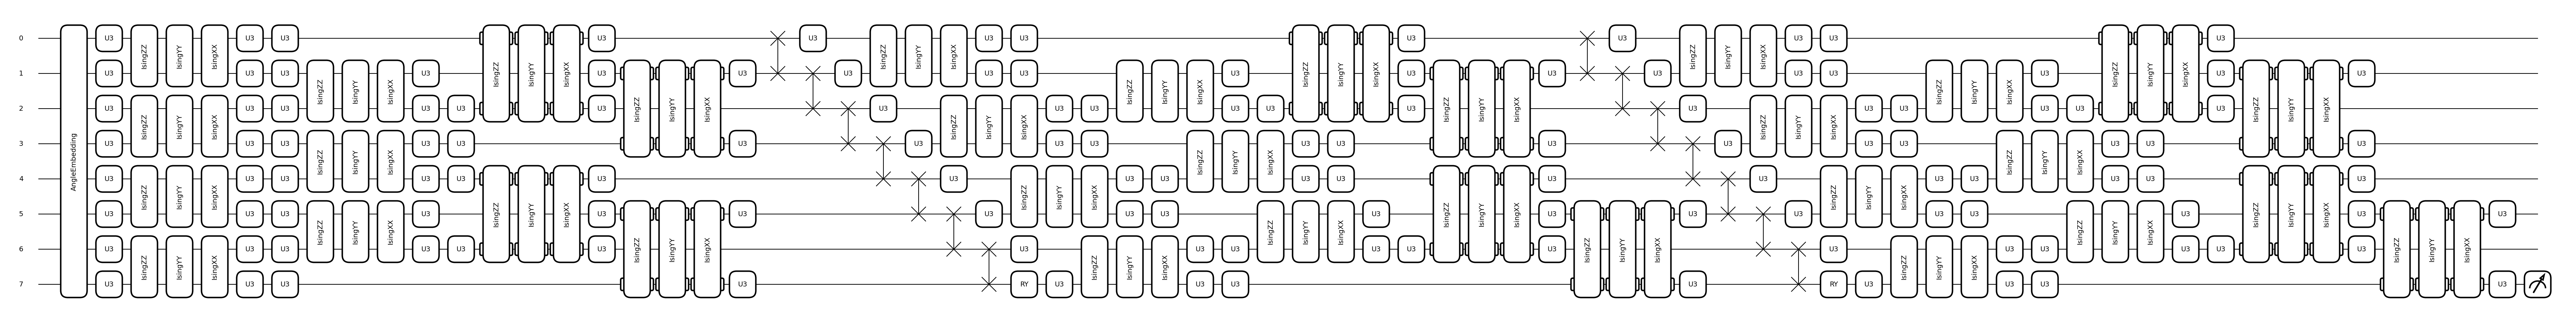

In [16]:
fig, ax = qml.draw_mpl(_circuit)(classical_features, conv_params)

# QTCN 3: (QCNN + Quantum Dilation, Causal) + Classical Residual

In [17]:
class QTCN3(nn.Module):
    """
    (THEORETICAL MODEL)
    Quantum Temporal Convolutional Network with a physical Quantum SWAP Chain.

    WARNING: This model is for educational purposes only and is not practical
    on any near-term quantum hardware due to extreme noise and circuit depth.

    It processes an entire time-series within a single, stateful quantum circuit,
    using qml.SWAP gates to implement the "conveyor belt".

    Args:
        input_channels (int): Number of features for each time step.
        receptive_field_size (int): The number of qubits, defining the processing window.
        n_layers (int): The number of stacked dilated convolutional layers.
        time_steps (int): The total number of time steps in the input sequence.
    """

    def __init__(self, receptive_field_size=8, n_layers=3, input_channels=64, time_steps=20):
        super(QTCN3, self).__init__()
        
        # Validate that the model is runnable
        if time_steps < receptive_field_size:
            raise ValueError("Total time_steps must be >= receptive_field_size.")
        if 2**(n_layers-1) > receptive_field_size:
            raise ValueError("The largest dilation factor cannot exceed the receptive field size.")

        self.receptive_field_size = receptive_field_size
        self.n_layers = n_layers
        self.input_channels = input_channels
        self.time_steps = time_steps

        # 1. Classical Feature Extraction
        self.feature_extractor = nn.Conv1d(
            in_channels=self.input_channels,
            out_channels=1,
            kernel_size=1
        )

        # 2. Quantum Parameters (Unchanged)
        self.conv_params = nn.Parameter(torch.randn(n_layers, 15))
        # 3. Quantum Device and QNode
        self.dev = qml.device("default.qubit", wires=self.receptive_field_size)        
        # The QNode now encapsulates the entire temporal evolution
        self.qnode = qml.QNode(self._circuit, self.dev, interface="torch")

    def _apply_dilated_conv(self, weights, dilation):
        """Applies a single layer of dilated convolution using the QCNN ansatz (Unchanged)."""
        for i in range(self.receptive_field_size - dilation):
            w1, w2 = i, i + dilation
            qml.U3(*weights[:3], wires=w1)
            qml.U3(*weights[3:6], wires=w2)
            qml.IsingZZ(weights[6], wires=[w1, w2])
            qml.IsingYY(weights[7], wires=[w1, w2])
            qml.IsingXX(weights[8], wires=[w1, w2])
            qml.U3(*weights[9:12], wires=w1)
            qml.U3(*weights[12:15], wires=w2)
            
    def _apply_swap_shift(self):
        """
        Applies a chain of SWAP gates to shift the quantum state one step to the next.
        q_state[i] -> q_state[i+1].
        """
        # shift the register left by one → conveyor‑belt SWAPs
        for i in range(self.receptive_field_size - 1):
            qml.SWAP(wires=[i, i+1])

    def _circuit(self, full_sequence, conv_params):
        """
        A single, giant quantum circuit that processes an entire time series.
        
        Args:
            full_sequence (torch.Tensor): The full, pre-processed time series for ONE sample.
            conv_params (torch.Tensor): The learnable parameters for all layers.
        """
        # 1. Initialize the circuit by encoding the first full window
        initial_window = full_sequence[:self.receptive_field_size]
        qml.AngleEmbedding(initial_window, wires=range(self.receptive_field_size), rotation='Y')

        # This will hold the expectation value from each time step
        predictions = []

        # 2. Main temporal loop WITHIN the quantum circuit
        for t in range(self.time_steps - self.receptive_field_size + 1):
            # A. Apply the dilated convolutional layers to the current state
            for layer_idx in range(self.n_layers):
                dilation = 2**layer_idx
                self._apply_dilated_conv(conv_params[layer_idx], dilation)
            
            # B. If not the last step, perform the physical quantum SWAP shift
            if t < self.time_steps - self.receptive_field_size:
                self._apply_swap_shift()
                
                # C. Encode the next new data point onto the now "vacant" last qubit
                next_sample = full_sequence[t + self.receptive_field_size]
                qml.RY(next_sample, wires=self.receptive_field_size - 1)
        
        # D. Measure the last qubit at the very end
        return qml.expval(qml.PauliZ(self.receptive_field_size-1))
    
    def forward(self, x):
        """
        The forward pass is now much simpler classically, as all temporal logic
        is inside the quantum circuit.
        """
        batch_size = x.shape[0]

        # Classically pre-process the data
        x = self.feature_extractor(x)
        x = x.squeeze(1)  # Shape becomes (batch_size, time_steps)

        # Loop over the batch, running the full quantum evolution for each sample
        batch_predictions = []
        for i in range(batch_size):
            # The qnode returns a list/tuple of scalar tensors
            predictions_for_sample = self.qnode(x[i], self.conv_params)
            # Stack them into a single tensor for this sample
            batch_predictions.append(predictions_for_sample)

        return torch.stack(batch_predictions)

## Circuit Visualization

In [18]:
receptive_field_size = 8
n_layers = 2
classical_features = np.random.rand(10)
conv_params = nn.Parameter(torch.randn(n_layers, 15))
time_steps=10

In [19]:
def _apply_dilated_conv(weights, dilation):
    """
    Applies a single layer of causal, dilated convolution using the QCNN ansatz.

    Args:
        weights (torch.Tensor): The learnable parameters for this layer, shape (15,).
        dilation (int): The dilation factor (d).
    """
    # The 15 parameters are shared across all pairs in this layer,
    # achieving the "weight sharing" of a classical convolution.
    for i in range(n_qubits - dilation):
        # Define the pair of qubits for the dilated interaction
        w1 = i
        w2 = i + dilation

        # Apply the sequence of gates from the QCNN ansatz
        qml.U3(*weights[:3], wires=w1)
        qml.U3(*weights[3:6], wires=w2)
        qml.IsingZZ(weights[6], wires=[w1, w2])
        qml.IsingYY(weights[7], wires=[w1, w2])
        qml.IsingXX(weights[8], wires=[w1, w2])
        qml.U3(*weights[9:12], wires=w1)
        qml.U3(*weights[12:15], wires=w2)


def _apply_swap_shift():
    """
    Applies a chain of SWAP gates to shift the quantum state one step to the left.
    q_state[i] -> q_state[i-1].
    """
    # shift the register left by one → conveyor‑belt SWAPs
    for i in range(receptive_field_size - 1):
        qml.SWAP(wires=[i, i+1])


def _circuit(full_sequence, conv_params):
    """
    A single, giant quantum circuit that processes an entire time series.
        
    Args:
        full_sequence (torch.Tensor): The full, pre-processed time series for ONE sample.
        conv_params (torch.Tensor): The learnable parameters for all layers.
    """
    # 1. Initialize the circuit by encoding the first full window
    initial_window = full_sequence[:receptive_field_size]
    qml.AngleEmbedding(initial_window, wires=range(receptive_field_size), rotation='Y')

    # This will hold the expectation value from each time step
    predictions = []

    # 2. Main temporal loop WITHIN the quantum circuit
    for t in range(time_steps - receptive_field_size + 1):
        # A. Apply the dilated convolutional layers to the current state
        for layer_idx in range(n_layers):
            dilation = 2**layer_idx
            _apply_dilated_conv(conv_params[layer_idx], dilation)
            
        # B. If not the last step, perform the physical quantum SWAP shift
        if t < time_steps - receptive_field_size:
            _apply_swap_shift()
                
            # C. Encode the next new data point onto the now "vacant" last qubit
            next_sample = full_sequence[t + receptive_field_size]
            qml.RY(next_sample, wires=receptive_field_size - 1)
        
    # D. Measure the last qubit at the very end
    return qml.expval(qml.PauliZ(receptive_field_size-1))

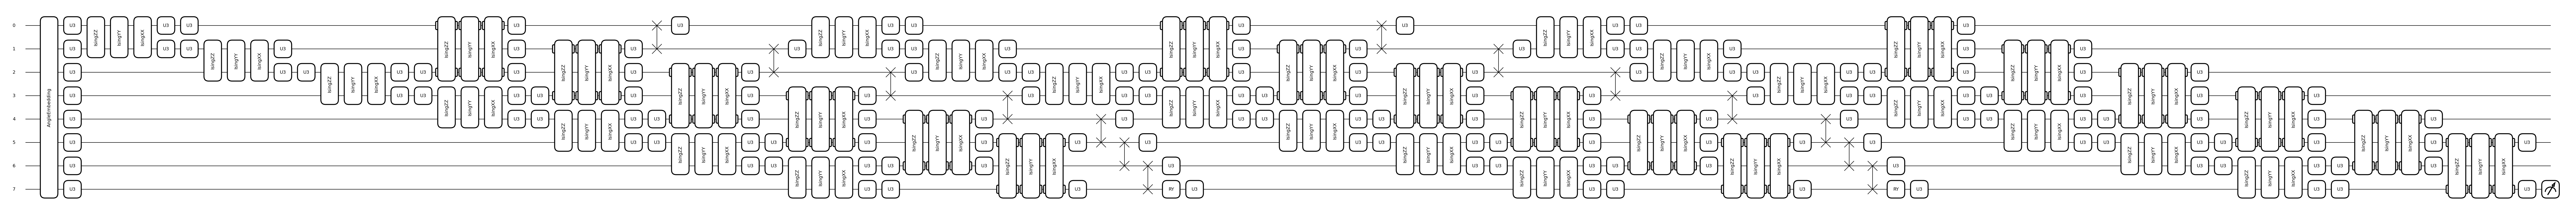

In [20]:
fig, ax = qml.draw_mpl(_circuit)(classical_features, conv_params)

# QTCN 4: QCNN + Quantum Dilation, Causal, Residual

In [21]:
class QuantumResidualBlock(nn.Module):
    """A single quantum residual block."""
    def __init__(self, n_layers=1):
        super().__init__()
        # The transformation 'F' is a stack of dilated convolutions.
        # For simplicity, we'll use n_layers=1 here, meaning one dilation per block.
        # Parameters for the U3/Ising-based convolution
        self.conv_params = nn.Parameter(torch.randn(n_layers, 15))
        # The learnable parameter 'alpha' that controls the residual connection
        self.residual_param = nn.Parameter(torch.randn(1))

        
class QTCN4(nn.Module):
    """
    (THEORETICAL MODEL)
    QTCN with physical Quantum SWAP Chains and Quantum Residual Blocks.

    This version adds an ancilla qubit to control the application of each
    convolutional block, creating a quantum analogue of a residual connection.
    """
    def __init__(self, receptive_field_size=8, n_residual_blocks=3, input_channels=64, time_steps=20):
        super().__init__()
        
        if time_steps < receptive_field_size:
            raise ValueError("Total time_steps must be >= receptive_field_size.")

        self.receptive_field_size = receptive_field_size
        self.n_residual_blocks = n_residual_blocks
        self.input_channels = input_channels
        self.time_steps = time_steps

        # Main processing wires and a dedicated ancilla for residual control
        self.main_wires = list(range(receptive_field_size))
        self.ancilla_wire = receptive_field_size # The last qubit is the ancilla
        
        # 1. Classical Feature Extraction
        self.feature_extractor = nn.Conv1d(
            in_channels=self.input_channels, out_channels=1, kernel_size=1)

        # 2. Quantum Residual Blocks
        # Create a list of residual blocks, each with its own learnable parameters.
        # The dilation factor will be determined by the block's index.
        self.residual_blocks = nn.ModuleList(
            [QuantumResidualBlock(n_layers=1) for _ in range(n_residual_blocks)]
        )

        # 3. Quantum Device and QNode
        # The number of qubits is now receptive_field_size + 1 (for the ancilla)
        self.dev = qml.device("default.qubit", wires=receptive_field_size + 1)
        self.qnode = qml.QNode(self._circuit, self.dev, interface="torch")

    def _apply_conv_ansatz(self, weights, dilation):
        """The core U3/Ising convolution ansatz (our 'F' transformation)."""
        for i in range(self.receptive_field_size - dilation):
            w1, w2 = self.main_wires[i], self.main_wires[i + dilation]
            qml.U3(*weights[:3], wires=w1)
            qml.U3(*weights[3:6], wires=w2)
            qml.IsingZZ(weights[6], wires=[w1, w2])
            qml.IsingYY(weights[7], wires=[w1, w2])
            qml.IsingXX(weights[8], wires=[w1, w2])
            qml.U3(*weights[9:12], wires=w1)
            qml.U3(*weights[12:15], wires=w2)

    def _apply_residual_block(self, block, dilation):
        """Applies a full residual block using ancilla control."""
        # 1. Put ancilla into a superposition controlled by the learnable parameter
        qml.RY(block.residual_param[0], wires=self.ancilla_wire)
        # 2. Apply the convolution, controlled by the ancilla
        # The 'qml.ctrl' function makes an operation conditional on a control qubit.
        qml.ctrl(self._apply_conv_ansatz, control=self.ancilla_wire)(block.conv_params[0], dilation)
        # 3. Uncompute the rotation on the ancilla to disentangle it
        qml.RY(-block.residual_param[0], wires=self.ancilla_wire)

    def _apply_swap_shift(self):
        """Applies a SWAP chain to the main processing wires only."""
        # shift the register left by one → conveyor‑belt SWAPs
        for i in range(self.receptive_field_size - 1):
            qml.SWAP(wires=[self.main_wires[i], self.main_wires[i+1]])    

    def _circuit(self, full_sequence):
        """The main quantum circuit with residual blocks."""
        initial_window = full_sequence[:self.receptive_field_size]
        qml.AngleEmbedding(initial_window, wires=self.main_wires)
        predictions = []
        for t in range(self.time_steps - self.receptive_field_size + 1):
            # Apply the stack of residual blocks
            for block_idx, block in enumerate(self.residual_blocks):
                dilation = 2**block_idx
                if dilation >= self.receptive_field_size: continue # Skip if dilation is too large
                self._apply_residual_block(block, dilation)
            # If not the last step, shift the state and encode the next sample
            if t < self.time_steps - self.receptive_field_size:
                self._apply_swap_shift()
                next_sample = full_sequence[t + self.receptive_field_size]
                qml.RY(next_sample, wires=self.main_wires[-1])
        # Measure the last main qubit
        return qml.expval(qml.PauliZ(self.main_wires[-1]))
    
    def forward(self, x):
        """The forward pass."""
        batch_size = x.shape[0]
        x = self.feature_extractor(x).squeeze(1)

        batch_predictions = []
        for i in range(batch_size):
            predictions_for_sample = self.qnode(x[i])
            batch_predictions.append(predictions_for_sample)

        return torch.stack(batch_predictions)

## Circuit Visualization

In [22]:
receptive_field_size = 8
n_layers = 2
n_residual_blocks = 1
classical_features = np.random.rand(10)
conv_params = nn.Parameter(torch.randn(n_layers, 15))
time_steps=10

In [23]:
main_wires = list(range(receptive_field_size))
residual_blocks = nn.ModuleList(
    [QuantumResidualBlock(n_layers=1) for _ in range(n_residual_blocks)]
)
ancilla_wire = receptive_field_size # The last qubit is the ancilla

class QuantumResidualBlock(nn.Module):
    """A single quantum residual block."""
    def __init__(self, n_layers=1):
        super().__init__()
        # The transformation 'F' is a stack of dilated convolutions.
        # For simplicity, we'll use n_layers=1 here, meaning one dilation per block.
        # Parameters for the U3/Ising-based convolution
        self.conv_params = nn.Parameter(torch.randn(n_layers, 15))
        # The learnable parameter 'alpha' that controls the residual connection
        self.residual_param = nn.Parameter(torch.randn(1))
        
def _apply_conv_ansatz(weights, dilation):
    """
    Applies a single layer of causal, dilated convolution using the QCNN ansatz.

    Args:
        weights (torch.Tensor): The learnable parameters for this layer, shape (15,).
        dilation (int): The dilation factor (d).
    """
    # The 15 parameters are shared across all pairs in this layer,
    # achieving the "weight sharing" of a classical convolution.
    for i in range(n_qubits - dilation):
        # Define the pair of qubits for the dilated interaction
        w1 = i
        w2 = i + dilation

        # Apply the sequence of gates from the QCNN ansatz
        qml.U3(*weights[:3], wires=w1)
        qml.U3(*weights[3:6], wires=w2)
        qml.IsingZZ(weights[6], wires=[w1, w2])
        qml.IsingYY(weights[7], wires=[w1, w2])
        qml.IsingXX(weights[8], wires=[w1, w2])
        qml.U3(*weights[9:12], wires=w1)
        qml.U3(*weights[12:15], wires=w2)


def _apply_swap_shift():
    """
    Applies a chain of SWAP gates to shift the quantum state one step to the left.
    q_state[i] -> q_state[i-1].
    """
    # Must loop from right to left to avoid overwriting states before they are swapped.
    for i in range(receptive_field_size - 1):
        qml.SWAP(wires=[i, i+1])

def _apply_residual_block(block, dilation):
    """Applies a full residual block using ancilla control."""
    # 1. Put ancilla into a superposition controlled by the learnable parameter
    qml.RY(block.residual_param[0], wires=ancilla_wire)
    # 2. Apply the convolution, controlled by the ancilla
    # The 'qml.ctrl' function makes an operation conditional on a control qubit.
    qml.ctrl(_apply_conv_ansatz, control=ancilla_wire)(block.conv_params[0], dilation)
    # 3. Uncompute the rotation on the ancilla to disentangle it
    qml.RY(-block.residual_param[0], wires=ancilla_wire)

def _circuit(full_sequence):
    """The main quantum circuit with residual blocks."""
    initial_window = full_sequence[:receptive_field_size]
    qml.AngleEmbedding(initial_window, wires=main_wires)
    predictions = []
    for t in range(time_steps - receptive_field_size + 1):
        # Apply the stack of residual blocks
        for block_idx, block in enumerate(residual_blocks):
            dilation = 2**block_idx
            if dilation >= receptive_field_size: continue # Skip if dilation is too large
            _apply_residual_block(block, dilation)
        # If not the last step, shift the state and encode the next sample
        if t < time_steps - receptive_field_size:
            _apply_swap_shift()
            next_sample = full_sequence[t + receptive_field_size]
            qml.RY(next_sample, wires=main_wires[-1])
    # Measure the last main qubit
    return qml.expval(qml.PauliZ(main_wires[-1]))

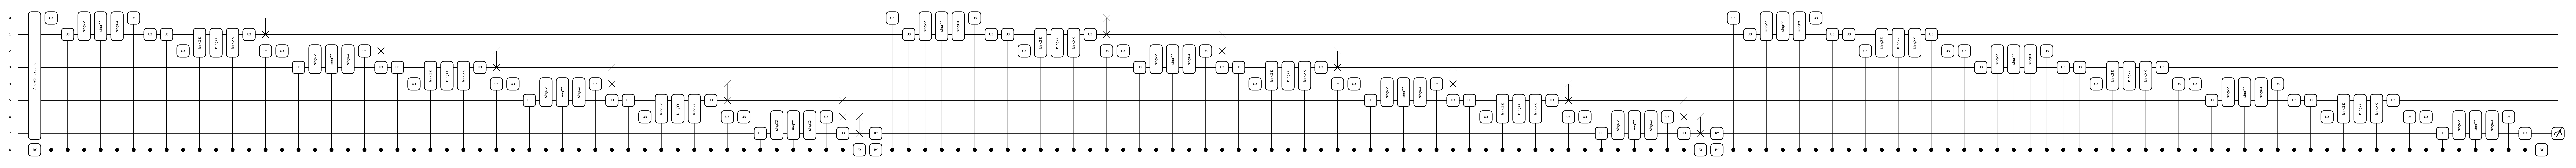

In [24]:
fig, ax = qml.draw_mpl(_circuit)(classical_features)

# Prepare PhysioNet EEG Dataset

Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. IEEE Transactions on Biomedical Engineering 51(6):1034-1043, 2004. https://mne.tools/stable/generated/mne.datasets.eegbci.load_data.html

In [8]:
def load_eeg_ts(seed, device, batch_size, sampling_freq):
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        
    # Load and preprocess the PhysioNet EEG Motor Imagery data
    N_SUBJECT = 50  # originally: 50
    IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST = [4, 8, 12]

    # Load data from PhysioNet (example assumes data is downloaded locally)
    physionet_paths = [
        mne.datasets.eegbci.load_data(
            subjects=subj_id,
            runs=IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST,
            path="PhysioNet_EEG",
        ) for subj_id in range(1, N_SUBJECT+1)
    ]
    physionet_paths = np.concatenate(physionet_paths)

    # Ensuring that all subjects share same sampling frequency
    # TARGET_SFREQ = 160  # 160 Hz sampling rate
    TARGET_SFREQ = sampling_freq

    # Concatenate all loaded raw data
    parts = []
    for path in physionet_paths:
        raw = mne.io.read_raw_edf(
            path,
            preload=True,
            stim_channel='auto',
            verbose='WARNING',
        )
        # Resample raw data to ensure consistent sfreq
        raw.resample(TARGET_SFREQ, npad="auto")
        parts.append(raw)
        
    # Concatenate resampled raw data
    raw = mne.concatenate_raws(parts)

    # Pick EEG channels and extract events
    eeg_channel_inds = mne.pick_types(
        raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads'
    )
    events, _ = mne.events_from_annotations(raw)

    # Epoch the data
    epoched = mne.Epochs(
        raw, events, dict(left=2, right=3), tmin=1, tmax=4.1,
        proj=False, picks=eeg_channel_inds, baseline=None, preload=True
    )

    # Convert data to NumPy arrays
    X = (epoched.get_data() * 1e3).astype(np.float32)  # Convert to millivolts
    y = (epoched.events[:, 2] - 2).astype(np.int64)  # 0: left, 1: right
    
    # Train-validation-test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)
    
    def MakeTensorDataset(X, y):
        ### CUDA memory DEBUGGING ###
        # X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        # y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        #############################
        tensordataset = TensorDataset(X_tensor, y_tensor)
        return tensordataset
    
    # Create datasets and dataloaders
    train_dataset = MakeTensorDataset(X_train, y_train)
    val_dataset = MakeTensorDataset(X_val, y_val)
    test_dataset = MakeTensorDataset(X_test, y_test)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    input_dim = X_train.shape
    
    return train_loader, val_loader, test_loader, input_dim

# Train & Evaluation Functions

In [9]:
################################# Calculate Running Time ########################################
def epoch_time(start_time: float, end_time: float) -> Tuple[float, float]:
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


################################# Performance & Density Matrices ################################
# Training loop
def train_perf(model, dataloader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    all_labels = []
    all_outputs = []
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure that data is on the same device (GPU or CPU)
        labels = labels.float()   # Ensure labels are of type float for BCEWithLogitsLoss
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Collect labels and outputs for AUROC
        all_labels.append(labels.cpu().numpy())
        all_outputs.append(outputs.detach().cpu().numpy())       
        
    # Calculate train AUROC
    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    train_auroc = roc_auc_score(all_labels, all_outputs)
    
    return train_loss / len(dataloader), train_auroc


# Validation/Test loop
def evaluate_perf(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure that data is on the same device (GPU or CPU)
            labels = labels.float()   # Ensure labels are of type float for BCEWithLogitsLoss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Collect labels and outputs for AUROC
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    auroc = roc_auc_score(all_labels, all_outputs)
    
    return running_loss / len(dataloader), auroc

In [10]:
def QuantumTCNN_run(model_type, n_qubits, circuit_depth, input_dim, kernel_size=None, dilation=None, num_epochs=10):
    print("Running on ", device)
    if model_type==1:
        model = QTCN(n_qubits, circuit_depth, input_dim, kernel_size, dilation).to(device)
    elif model_type==2:
        model = QTCN2(n_qubits, circuit_depth, input_dim[1]).to(device)
    elif model_type==3:
        model = QTCN3(n_qubits, circuit_depth, input_dim[1], input_dim[2]).to(device)
    elif model_type==4:
        model = QTCN4(n_qubits, circuit_depth, input_dim[1], input_dim[2]).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)
        
    # Training process
    train_metrics, valid_metrics, test_metrics = [], [], []
        
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        train_metrics.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_auc': train_auc})    
    
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        valid_metrics.append({'epoch': epoch + 1, 'valid_loss': valid_loss, 'valid_auc': valid_auc})
    
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    # Final evaluation on the test set
    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, AUC: {test_auc:.4f}")
    test_metrics.append({'epoch': num_epochs, 'test_loss': test_loss, 'test_auc': test_auc}) 

    # Combine all metrics into a pandas DataFrame
    metrics = []
    for epoch in range(num_epochs):
        metrics.append({
            'epoch': epoch + 1,
            'train_loss': train_metrics[epoch]['train_loss'],
            'train_auc': train_metrics[epoch]['train_auc'],
            'valid_loss': valid_metrics[epoch]['valid_loss'],
            'valid_auc': valid_metrics[epoch]['valid_auc'],
            'test_loss': test_metrics[0]['test_loss'],
            'test_auc': test_metrics[0]['test_auc'],
        })
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics)
    # Save to CSV
    csv_filename = f"QuantumTCNN{model_type}_performance.csv"
    metrics_df.to_csv(csv_filename, index=False)
    print(f"Metrics saved to {csv_filename}")
        
    return test_loss, test_auc

In [11]:
def QuantumTCNN_GPT_run(n_qubits, circuit_depth, input_dim, num_epochs):
    print("Running on ", device)
    model = QTCN_GPT(n_qubits=n_qubits, n_layers=circuit_depth, 
                  dilations=(1, 2), in_channels=input_dim[1], time_steps=input_dim[2]).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)
        
    # Training process
    train_metrics, valid_metrics, test_metrics = [], [], []
        
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        train_metrics.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_auc': train_auc})    
    
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        valid_metrics.append({'epoch': epoch + 1, 'valid_loss': valid_loss, 'valid_auc': valid_auc})
    
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    # Final evaluation on the test set
    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, AUC: {test_auc:.4f}")
    test_metrics.append({'epoch': num_epochs, 'test_loss': test_loss, 'test_auc': test_auc}) 

    # Combine all metrics into a pandas DataFrame
    metrics = []
    for epoch in range(num_epochs):
        metrics.append({
            'epoch': epoch + 1,
            'train_loss': train_metrics[epoch]['train_loss'],
            'train_auc': train_metrics[epoch]['train_auc'],
            'valid_loss': valid_metrics[epoch]['valid_loss'],
            'valid_auc': valid_metrics[epoch]['valid_auc'],
            'test_loss': test_metrics[0]['test_loss'],
            'test_auc': test_metrics[0]['test_auc'],
        })
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics)
    # Save to CSV
    csv_filename = f"QuantumTCNN_GPT_performance.csv"
    metrics_df.to_csv(csv_filename, index=False)
    print(f"Metrics saved to {csv_filename}")
        
    return test_loss, test_auc

# Load Dataset

In [12]:
train_loader, val_loader, test_loader, input_dim = load_eeg_ts(seed=2025, device=device, batch_size=32, sampling_freq=4)  # originally: batch_size=32

Download complete in 20s (7.3 MB)


Download complete in 18s (7.3 MB)


Download complete in 18s (7.3 MB)


Download complete in 19s (7.3 MB)


Download complete in 19s (7.4 MB)


Download complete in 21s (7.4 MB)


Download complete in 20s (7.3 MB)


Download complete in 19s (7.3 MB)


Download complete in 19s (7.3 MB)


Download complete in 19s (7.3 MB)


Download complete in 20s (7.3 MB)


Download complete in 20s (7.3 MB)


Download complete in 21s (7.4 MB)


Download complete in 21s (7.4 MB)


Download complete in 19s (7.3 MB)


Download complete in 20s (7.4 MB)


Download complete in 19s (7.3 MB)


Download complete in 20s (7.3 MB)


Download complete in 20s (7.4 MB)


Download complete in 19s (7.3 MB)


Download complete in 18s (7.3 MB)


Download complete in 19s (7.3 MB)


Download complete in 19s (7.3 MB)


Download complete in 19s (7.3 MB)


Download complete in 19s (7.4 MB)


Download complete in 18s (7.3 MB)


Download complete in 19s (7.3 MB)


Download complete in 19s (7.3 MB)


Download complete in 19s (7.3 MB)


Download complete in 20s (7.4 MB)


Download complete in 19s (7.3 MB)


Download complete in 18s (7.3 MB)


Download complete in 19s (7.3 MB)


Download complete in 19s (7.3 MB)
Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
2250 matching events found
No baseline correction applied
Using data from preloaded Raw for 2250 events and 13 original time points ...
116 bad epochs dropped


In [13]:
input_dim

(1493, 64, 13)

# Run Models

In [15]:
QuantumTCNN_run(model_type=1, n_qubits=8, circuit_depth=2, input_dim=input_dim, kernel_size=6, dilation=2, num_epochs=10)

Running on  cuda


100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


Epoch: 01 | Time: 0m 17s
Train Loss: 0.6963, AUC: 0.5597 | Validation Loss: 0.6951, AUC: 0.6029


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Epoch: 02 | Time: 0m 16s
Train Loss: 0.6894, AUC: 0.6324 | Validation Loss: 0.6925, AUC: 0.6128


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Epoch: 03 | Time: 0m 16s
Train Loss: 0.6841, AUC: 0.6738 | Validation Loss: 0.6901, AUC: 0.6338


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Epoch: 04 | Time: 0m 16s
Train Loss: 0.6797, AUC: 0.6876 | Validation Loss: 0.6884, AUC: 0.6405


100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


Epoch: 05 | Time: 0m 16s
Train Loss: 0.6751, AUC: 0.7102 | Validation Loss: 0.6856, AUC: 0.6543


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Epoch: 06 | Time: 0m 16s
Train Loss: 0.6707, AUC: 0.7109 | Validation Loss: 0.6831, AUC: 0.6601


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Epoch: 07 | Time: 0m 16s
Train Loss: 0.6662, AUC: 0.7304 | Validation Loss: 0.6811, AUC: 0.6730


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Epoch: 08 | Time: 0m 16s
Train Loss: 0.6616, AUC: 0.7389 | Validation Loss: 0.6783, AUC: 0.6806


100%|██████████| 10/10 [00:01<00:00,  6.89it/s]


Epoch: 09 | Time: 0m 15s
Train Loss: 0.6579, AUC: 0.7447 | Validation Loss: 0.6755, AUC: 0.6869


100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


Epoch: 10 | Time: 0m 16s
Train Loss: 0.6531, AUC: 0.7589 | Validation Loss: 0.6732, AUC: 0.6951


100%|██████████| 11/11 [00:01<00:00,  6.77it/s]

Test Loss: 0.6566, AUC: 0.7236
Metrics saved to QuantumTCNN1_performance.csv


(0.6565954901955344, 0.7235990528808208)

In [56]:
QuantumTCNN_run(model_type=1, n_qubits=8, circuit_depth=2, input_dim=input_dim, kernel_size=6, dilation=2, num_epochs=10)

Running on  cuda


100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Epoch: 01 | Time: 0m 14s
Train Loss: 0.6914, AUC: 0.5745 | Validation Loss: 0.6922, AUC: 0.6308


100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Epoch: 02 | Time: 0m 14s
Train Loss: 0.6844, AUC: 0.6655 | Validation Loss: 0.6901, AUC: 0.6335


100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Epoch: 03 | Time: 0m 14s
Train Loss: 0.6784, AUC: 0.6940 | Validation Loss: 0.6879, AUC: 0.6573


100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Epoch: 04 | Time: 0m 14s
Train Loss: 0.6730, AUC: 0.7072 | Validation Loss: 0.6857, AUC: 0.6626


100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Epoch: 05 | Time: 0m 14s
Train Loss: 0.6684, AUC: 0.7197 | Validation Loss: 0.6829, AUC: 0.6813


100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Epoch: 06 | Time: 0m 14s
Train Loss: 0.6637, AUC: 0.7311 | Validation Loss: 0.6807, AUC: 0.6829


100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Epoch: 07 | Time: 0m 14s
Train Loss: 0.6601, AUC: 0.7403 | Validation Loss: 0.6788, AUC: 0.6885


100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Epoch: 08 | Time: 0m 14s
Train Loss: 0.6567, AUC: 0.7487 | Validation Loss: 0.6765, AUC: 0.6907


100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Epoch: 09 | Time: 0m 14s
Train Loss: 0.6530, AUC: 0.7515 | Validation Loss: 0.6738, AUC: 0.6937


100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Epoch: 10 | Time: 0m 16s
Train Loss: 0.6497, AUC: 0.7550 | Validation Loss: 0.6719, AUC: 0.6962


100%|██████████| 11/11 [00:01<00:00,  8.21it/s]

Test Loss: 0.6497, AUC: 0.7295
Metrics saved to QuantumTCNN1_performance.csv


(0.649661817333915, 0.7294790844514601)

In [16]:
QuantumTCNN_run(model_type=2, n_qubits=8, circuit_depth=2, input_dim=input_dim, kernel_size=None, dilation=None, num_epochs=10)

Running on  cuda


100%|██████████| 10/10 [01:42<00:00, 10.25s/it]


Epoch: 01 | Time: 21m 27s
Train Loss: 0.6935, AUC: 0.5057 | Validation Loss: 0.6931, AUC: 0.5736


100%|██████████| 10/10 [01:41<00:00, 10.16s/it]


Epoch: 02 | Time: 21m 10s
Train Loss: 0.6931, AUC: 0.5019 | Validation Loss: 0.6930, AUC: 0.5859


100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


Epoch: 03 | Time: 21m 20s
Train Loss: 0.6926, AUC: 0.5464 | Validation Loss: 0.6930, AUC: 0.5879


100%|██████████| 10/10 [01:44<00:00, 10.45s/it]


Epoch: 04 | Time: 21m 21s
Train Loss: 0.6923, AUC: 0.5689 | Validation Loss: 0.6929, AUC: 0.5917


100%|██████████| 10/10 [01:44<00:00, 10.43s/it]


Epoch: 05 | Time: 21m 16s
Train Loss: 0.6920, AUC: 0.5448 | Validation Loss: 0.6929, AUC: 0.5985


100%|██████████| 10/10 [01:44<00:00, 10.46s/it]


Epoch: 06 | Time: 21m 28s
Train Loss: 0.6912, AUC: 0.6038 | Validation Loss: 0.6928, AUC: 0.6015


100%|██████████| 10/10 [01:42<00:00, 10.23s/it]


Epoch: 07 | Time: 21m 18s
Train Loss: 0.6905, AUC: 0.6217 | Validation Loss: 0.6926, AUC: 0.6068


100%|██████████| 10/10 [01:45<00:00, 10.53s/it]


Epoch: 08 | Time: 21m 31s
Train Loss: 0.6899, AUC: 0.6269 | Validation Loss: 0.6925, AUC: 0.6091


100%|██████████| 10/10 [01:44<00:00, 10.44s/it]


Epoch: 09 | Time: 21m 44s
Train Loss: 0.6893, AUC: 0.6287 | Validation Loss: 0.6922, AUC: 0.6139


100%|██████████| 10/10 [01:42<00:00, 10.24s/it]


Epoch: 10 | Time: 21m 25s
Train Loss: 0.6885, AUC: 0.6361 | Validation Loss: 0.6921, AUC: 0.6155


100%|██████████| 11/11 [01:42<00:00,  9.36s/it]

Test Loss: 0.6909, AUC: 0.6675
Metrics saved to QuantumTCNN2_performance.csv


(0.6909329349344427, 0.6674822415153907)

In [17]:
QuantumTCNN_run(model_type=3, n_qubits=8, circuit_depth=2, input_dim=input_dim, kernel_size=None, dilation=None, num_epochs=10)

Running on  cuda


100%|██████████| 10/10 [01:38<00:00,  9.89s/it]


Epoch: 01 | Time: 20m 47s
Train Loss: 0.6930, AUC: 0.4911 | Validation Loss: 0.6933, AUC: 0.5377


100%|██████████| 10/10 [01:40<00:00, 10.03s/it]


Epoch: 02 | Time: 20m 40s
Train Loss: 0.6928, AUC: 0.5250 | Validation Loss: 0.6932, AUC: 0.5548


100%|██████████| 10/10 [01:38<00:00,  9.87s/it]


Epoch: 03 | Time: 20m 45s
Train Loss: 0.6928, AUC: 0.5150 | Validation Loss: 0.6932, AUC: 0.5638


100%|██████████| 10/10 [01:38<00:00,  9.85s/it]


Epoch: 04 | Time: 20m 46s
Train Loss: 0.6922, AUC: 0.5489 | Validation Loss: 0.6930, AUC: 0.5803


100%|██████████| 10/10 [01:42<00:00, 10.22s/it]


Epoch: 05 | Time: 21m 2s
Train Loss: 0.6918, AUC: 0.5620 | Validation Loss: 0.6927, AUC: 0.5908


100%|██████████| 10/10 [01:41<00:00, 10.13s/it]


Epoch: 06 | Time: 20m 40s
Train Loss: 0.6911, AUC: 0.5781 | Validation Loss: 0.6924, AUC: 0.5984


100%|██████████| 10/10 [01:39<00:00,  9.97s/it]


Epoch: 07 | Time: 20m 52s
Train Loss: 0.6903, AUC: 0.5981 | Validation Loss: 0.6922, AUC: 0.6086


100%|██████████| 10/10 [01:40<00:00, 10.04s/it]


Epoch: 08 | Time: 20m 55s
Train Loss: 0.6897, AUC: 0.6119 | Validation Loss: 0.6917, AUC: 0.6119


100%|██████████| 10/10 [01:45<00:00, 10.57s/it]


Epoch: 09 | Time: 21m 12s
Train Loss: 0.6886, AUC: 0.6322 | Validation Loss: 0.6911, AUC: 0.6201


100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


Epoch: 10 | Time: 21m 11s
Train Loss: 0.6878, AUC: 0.6349 | Validation Loss: 0.6904, AUC: 0.6255


100%|██████████| 11/11 [01:42<00:00,  9.29s/it]

Test Loss: 0.6885, AUC: 0.6686
Metrics saved to QuantumTCNN3_performance.csv


(0.6884534467350353, 0.6685872138910812)

In [18]:
QuantumTCNN_run(model_type=4, n_qubits=8, circuit_depth=2, input_dim=input_dim, kernel_size=None, dilation=None, num_epochs=10)

Running on  cuda


100%|██████████| 10/10 [04:00<00:00, 24.08s/it]


Epoch: 01 | Time: 36m 12s
Train Loss: 0.7622, AUC: 0.5020 | Validation Loss: 0.7534, AUC: 0.5734


100%|██████████| 10/10 [04:03<00:00, 24.30s/it]


Epoch: 02 | Time: 36m 18s
Train Loss: 0.7389, AUC: 0.5029 | Validation Loss: 0.7274, AUC: 0.5742


100%|██████████| 10/10 [04:00<00:00, 24.10s/it]


Epoch: 03 | Time: 36m 0s
Train Loss: 0.7144, AUC: 0.5062 | Validation Loss: 0.7051, AUC: 0.5621


100%|██████████| 10/10 [03:57<00:00, 23.73s/it]


Epoch: 04 | Time: 35m 30s
Train Loss: 0.6998, AUC: 0.5012 | Validation Loss: 0.6967, AUC: 0.5382


100%|██████████| 10/10 [03:58<00:00, 23.80s/it]


Epoch: 05 | Time: 35m 41s
Train Loss: 0.6949, AUC: 0.5135 | Validation Loss: 0.6942, AUC: 0.5395


100%|██████████| 10/10 [03:59<00:00, 23.92s/it]


Epoch: 06 | Time: 35m 26s
Train Loss: 0.6937, AUC: 0.5027 | Validation Loss: 0.6933, AUC: 0.5422


100%|██████████| 10/10 [04:01<00:00, 24.16s/it]


Epoch: 07 | Time: 35m 22s
Train Loss: 0.6935, AUC: 0.4903 | Validation Loss: 0.6935, AUC: 0.5525


100%|██████████| 10/10 [03:56<00:00, 23.70s/it]


Epoch: 08 | Time: 35m 36s
Train Loss: 0.6938, AUC: 0.5093 | Validation Loss: 0.6926, AUC: 0.5440


100%|██████████| 10/10 [03:52<00:00, 23.24s/it]


Epoch: 09 | Time: 35m 9s
Train Loss: 0.6930, AUC: 0.5054 | Validation Loss: 0.6925, AUC: 0.5464


100%|██████████| 10/10 [04:00<00:00, 24.02s/it]


Epoch: 10 | Time: 36m 4s
Train Loss: 0.6928, AUC: 0.5036 | Validation Loss: 0.6925, AUC: 0.5503


100%|██████████| 11/11 [03:59<00:00, 21.76s/it]

Test Loss: 0.6936, AUC: 0.4857
Metrics saved to QuantumTCNN4_performance.csv


(0.6935912533239885, 0.48571428571428565)

# Added by Maria

## Original (wrong) vs. edited QCNN

### QTCN (QCNN with time sliding window) with final measurement at a wrong qubit

In [16]:
class QCNN_TimeSliding(nn.Module):
    """
    A QCNN model that incorporates a classical time-sliding window.
    - No dilation (dilation is fixed at 1).
    - No residual connection.
    - Keeps the original QCNN's incorrect measurement of the last qubit.
    """
    def __init__(self, n_qubits, circuit_depth, input_dim, kernel_size):
        super(QCNN_TimeSliding, self).__init__()
        self.n_qubits = n_qubits
        self.circuit_depth = circuit_depth

        # Quantum parameters (from QCNN)
        self.conv_params = nn.Parameter(torch.randn(circuit_depth, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))
        self.dev = qml.device("default.qubit", wires=n_qubits)

        # Classical layer setup (from QTCN)
        self.input_channels = input_dim[1]
        self.time_steps = input_dim[2]
        self.kernel_size = kernel_size
        self.fc = nn.Linear(self.input_channels * self.kernel_size, n_qubits)

    def circuit(self, features):
        """ The buggy quantum circuit from the original QCNN. """
        wires = list(range(self.n_qubits))
        qml.AngleEmbedding(features, wires=wires, rotation='Y')
        for layer in range(self.circuit_depth):
            self._apply_convolution(self.conv_params[layer], wires)
            self._apply_pooling(self.pool_params[layer], wires)
            wires = wires[::2]
        # Incorrect measurement of the original last qubit
        return qml.expval(qml.PauliZ(self.n_qubits - 1))

    def forward(self, x):
        """ Forward pass with the time-sliding window logic. """
        batch_size, _, time_steps = x.size()
        quantum_circuit = qml.QNode(self.circuit, self.dev, interface="torch")
        
        output = []
        # Slide a window of size kernel_size across the time steps
        for i in range(time_steps - self.kernel_size + 1):
            window = x[:, :, i : i + self.kernel_size].reshape(batch_size, -1)
            
            # Classical dimension reduction (no residual connection)
            reduced_window = self.fc(window)
            
            # Append the output of the quantum circuit
            output.append(quantum_circuit(reduced_window))
            
        # Aggregate the outputs from each window
        output = torch.mean(torch.stack(output, dim=1), dim=1)
        return output

    def _apply_convolution(self, weights, wires):
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

Generating visualization for the QCNN_TimeSliding model...


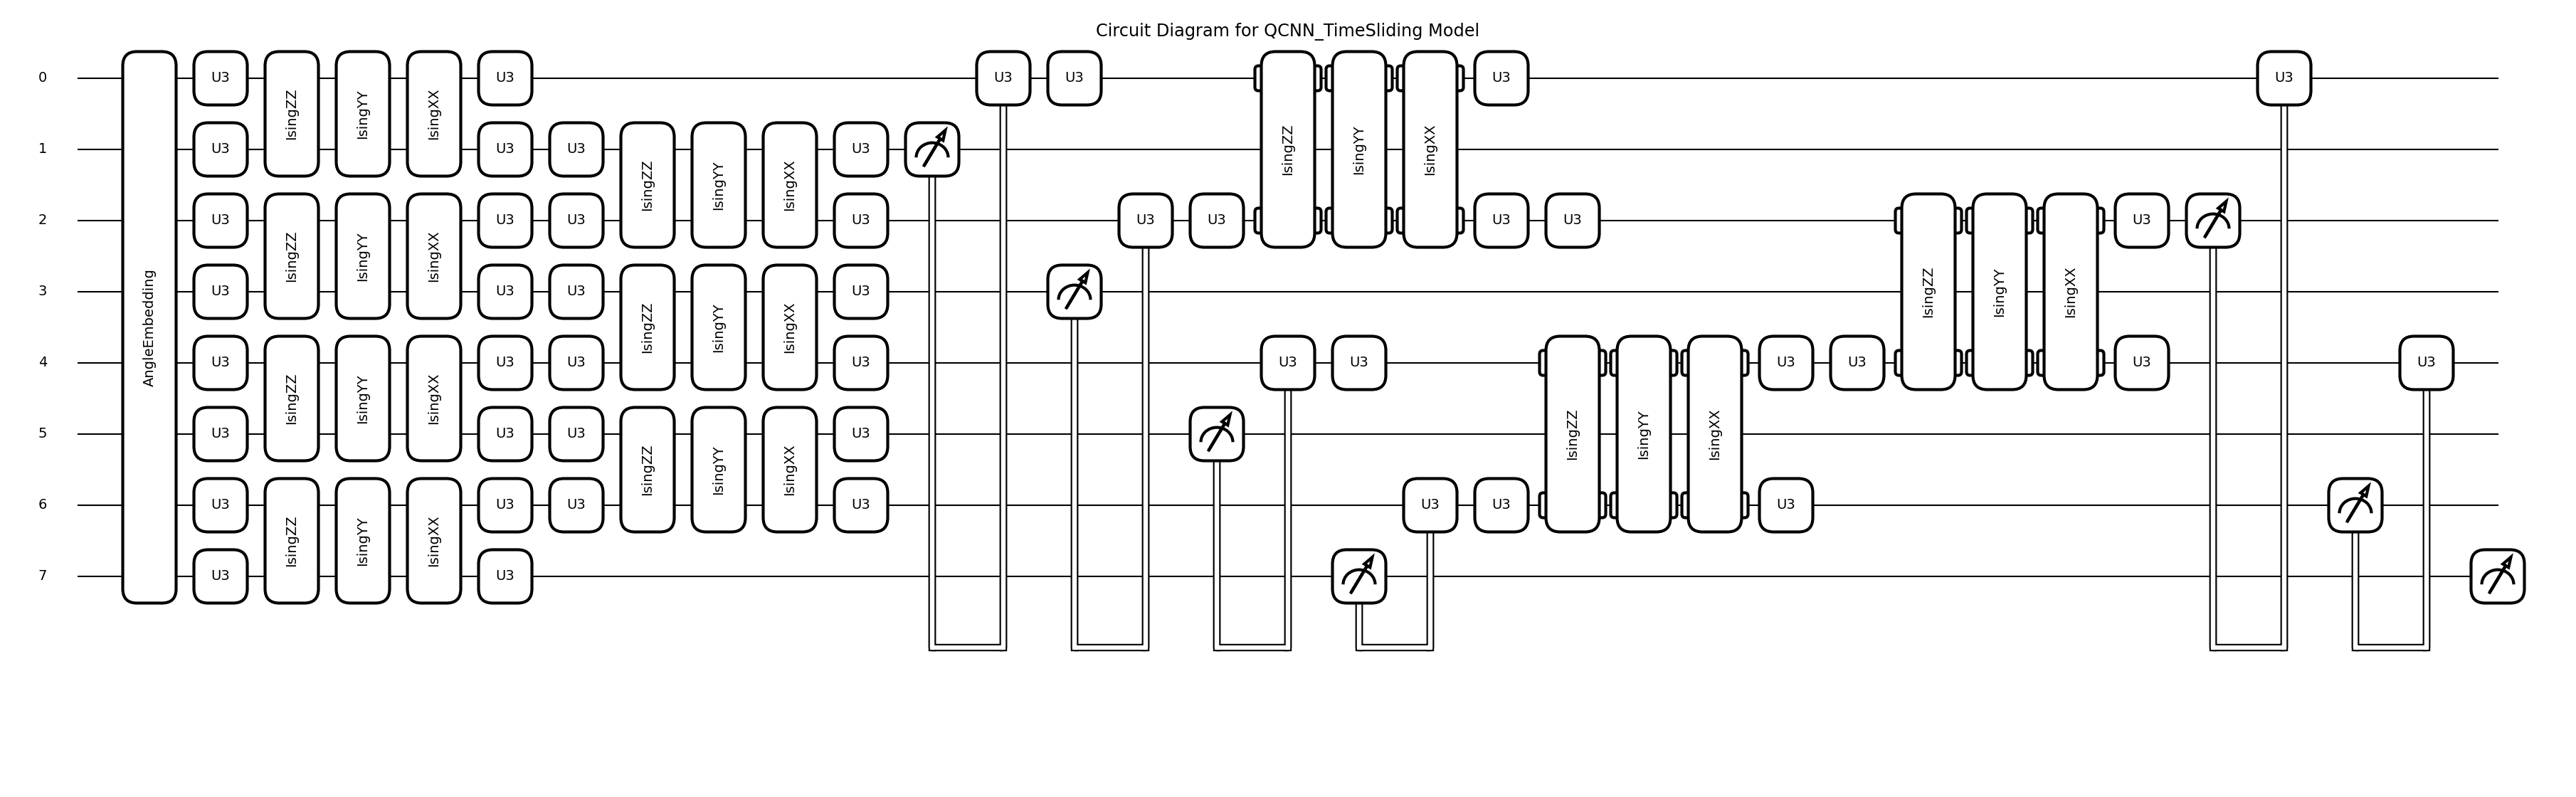

In [17]:
import matplotlib.pyplot as plt

# --- Visualization for the QCNN_TimeSliding Model ---

print("Generating visualization for the QCNN_TimeSliding model...")

# 1. Instantiate the model with the same parameters as the experiment
# Assumes 'input_dim' is available from your data loading step.
vis_model = QCNN_TimeSliding(
    n_qubits=8,
    circuit_depth=2,
    input_dim=input_dim,
    kernel_size=6
)

# 2. Create a QNode from the model's circuit method
# The interface is set to 'torch' to match the model's framework.
vis_qnode = qml.QNode(vis_model.circuit, vis_model.dev, interface="torch")

# 3. Create a dummy feature vector for the circuit to draw
# The circuit's AngleEmbedding layer expects a feature vector of size n_qubits.
dummy_features_for_vis = torch.randn(vis_model.n_qubits)

# 4. Draw the circuit using PennyLane's matplotlib drawer
fig, ax = qml.draw_mpl(vis_qnode)(dummy_features_for_vis)
fig.suptitle("Circuit Diagram for QCNN_TimeSliding Model", fontsize="xx-large")
plt.show()

In [18]:
def QCNN_TimeSliding_experiment(n_qubits, circuit_depth, input_dim, kernel_size, num_epochs=10):
    """
    A dedicated function to run the QCNN_TimeSliding experiment.
    """
    print("Running on ", device)
    
    # Instantiate our new model
    model = QCNN_TimeSliding(n_qubits, circuit_depth, input_dim, kernel_size).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)

    # --- Training and Evaluation (copied from original runner) ---
    train_metrics, valid_metrics, test_metrics = [], [], []
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        train_metrics.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_auc': train_auc})   
    
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        valid_metrics.append({'epoch': epoch + 1, 'valid_loss': valid_loss, 'valid_auc': valid_auc})
    
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}")
    
    # You can also add the metric saving logic here if you wish.
    
    return test_loss, test_auc

# --- Execute the experiment ---
# Using the same parameters as the original QTCN 1 run
print("--- Starting Experiment 1: QCNN with Time Sliding Window ---")
QCNN_TimeSliding_experiment(
    n_qubits=8,
    circuit_depth=2,
    input_dim=input_dim,  # Assumes 'input_dim' is loaded from your data
    kernel_size=6,
    num_epochs=10
)

--- Starting Experiment 1: QCNN with Time Sliding Window ---
Running on  cuda


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch: 01 | Time: 0m 39s
Train Loss: 0.7568, AUC: 0.5473 | Validation Loss: 0.7475, AUC: 0.5597


100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Epoch: 02 | Time: 0m 39s
Train Loss: 0.7307, AUC: 0.5554 | Validation Loss: 0.7246, AUC: 0.5667


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch: 03 | Time: 0m 39s
Train Loss: 0.7109, AUC: 0.5689 | Validation Loss: 0.7099, AUC: 0.5739


100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch: 04 | Time: 0m 39s
Train Loss: 0.6973, AUC: 0.5809 | Validation Loss: 0.7006, AUC: 0.5814


100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Epoch: 05 | Time: 0m 39s
Train Loss: 0.6889, AUC: 0.5931 | Validation Loss: 0.6942, AUC: 0.5886


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Epoch: 06 | Time: 0m 39s
Train Loss: 0.6838, AUC: 0.5983 | Validation Loss: 0.6894, AUC: 0.5951


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch: 07 | Time: 0m 39s
Train Loss: 0.6801, AUC: 0.6081 | Validation Loss: 0.6870, AUC: 0.5999


100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch: 08 | Time: 0m 40s
Train Loss: 0.6778, AUC: 0.6161 | Validation Loss: 0.6845, AUC: 0.6070


100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Epoch: 09 | Time: 0m 41s
Train Loss: 0.6756, AUC: 0.6266 | Validation Loss: 0.6825, AUC: 0.6124


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch: 10 | Time: 0m 40s
Train Loss: 0.6734, AUC: 0.6370 | Validation Loss: 0.6811, AUC: 0.6203


100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


Final Test Results:
Test Loss: 0.6827, Test AUC: 0.6485


(0.6827140125361356, 0.6484609313338594)

### QTCN with (right) final measurement at one of the remaining qubits

In [19]:
class QCNN_TimeSliding_Corrected(nn.Module):
    """
    This version corrects the measurement bug from the previous model.
    - Final measurement is performed on an active qubit (`wires[0]`).
    - All other logic (sliding window, no residuals) remains the same.
    """
    def __init__(self, n_qubits, circuit_depth, input_dim, kernel_size):
        super(QCNN_TimeSliding_Corrected, self).__init__()
        self.n_qubits = n_qubits
        self.circuit_depth = circuit_depth

        self.conv_params = nn.Parameter(torch.randn(circuit_depth, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))
        self.dev = qml.device("default.qubit", wires=n_qubits)

        self.input_channels = input_dim[1]
        self.time_steps = input_dim[2]
        self.kernel_size = kernel_size
        self.fc = nn.Linear(self.input_channels * self.kernel_size, n_qubits)

    def circuit(self, features):
        """ The quantum circuit with the corrected measurement. """
        wires = list(range(self.n_qubits))
        qml.AngleEmbedding(features, wires=wires, rotation='Y')
        for layer in range(self.circuit_depth):
            self._apply_convolution(self.conv_params[layer], wires)
            self._apply_pooling(self.pool_params[layer], wires)
            wires = wires[::2]
        
        # --- THIS LINE IS NOW CORRECTED ---
        return qml.expval(qml.PauliZ(wires[0]))

    def forward(self, x):
        batch_size, _, time_steps = x.size()
        quantum_circuit = qml.QNode(self.circuit, self.dev, interface="torch")
        
        output = []
        for i in range(time_steps - self.kernel_size + 1):
            window = x[:, :, i : i + self.kernel_size].reshape(batch_size, -1)
            reduced_window = self.fc(window)
            output.append(quantum_circuit(reduced_window))
            
        output = torch.mean(torch.stack(output, dim=1), dim=1)
        return output

    def _apply_convolution(self, weights, wires):
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

Generating visualization for the Corrected model...


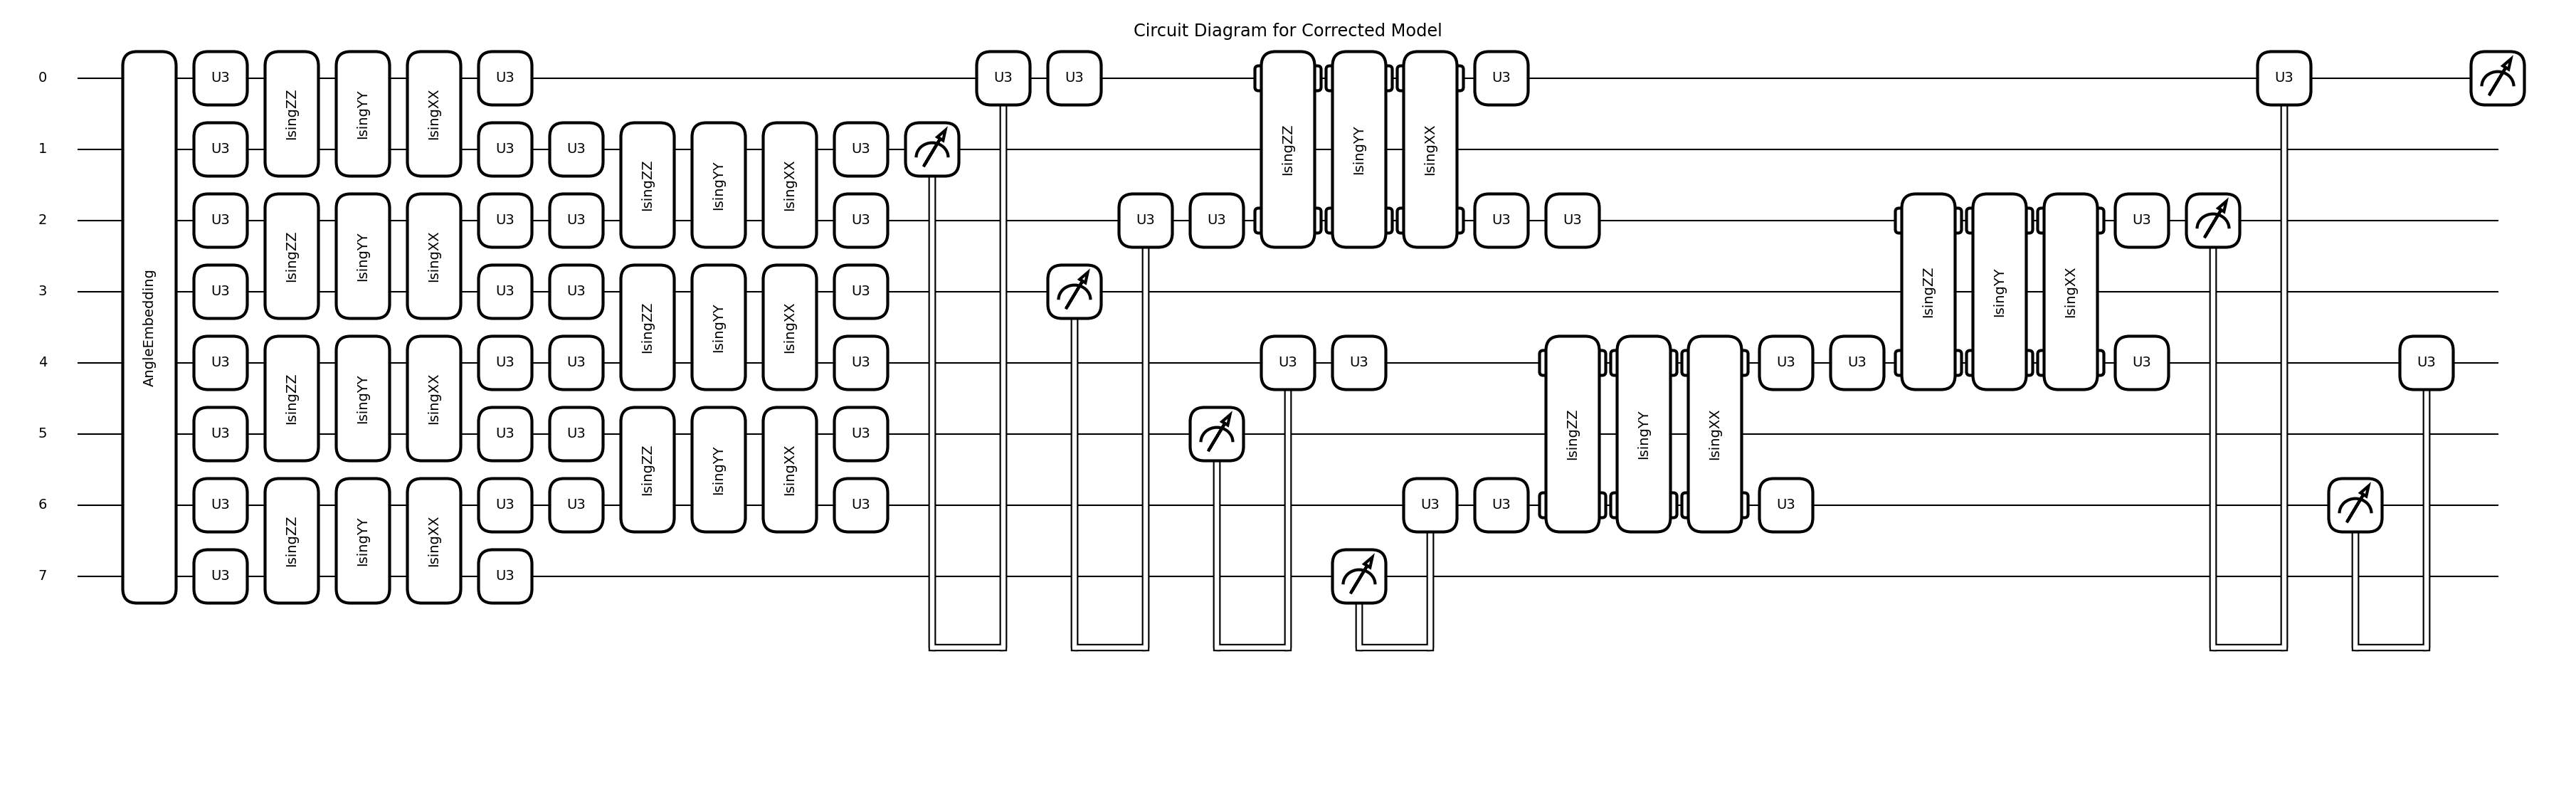

In [20]:
import matplotlib.pyplot as plt

print("Generating visualization for the Corrected model...")

# Instantiate the corrected model
vis_model_corrected = QCNN_TimeSliding_Corrected(
    n_qubits=8,
    circuit_depth=2,
    input_dim=input_dim,
    kernel_size=6
)

# Create a QNode from the corrected circuit
vis_qnode_corrected = qml.QNode(vis_model_corrected.circuit, vis_model_corrected.dev, interface="torch")

# Create dummy features and draw the circuit
dummy_features_for_vis = torch.randn(vis_model_corrected.n_qubits)
fig, ax = qml.draw_mpl(vis_qnode_corrected)(dummy_features_for_vis)
fig.suptitle("Circuit Diagram for Corrected Model", fontsize="xx-large")
plt.show()

In [21]:
def Corrected_Experiment_run(n_qubits, circuit_depth, input_dim, kernel_size, num_epochs=10):
    """
    A dedicated function to run the corrected model experiment.
    """
    print("Running on ", device)
    
    # Instantiate our new corrected model
    model = QCNN_TimeSliding_Corrected(n_qubits, circuit_depth, input_dim, kernel_size).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)

    # --- Training and Evaluation Loop ---
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"\nFinal Test Results for Corrected Model:")
    print(f"Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}")
    
    return test_loss, test_auc

# --- Execute the experiment ---
print("\n--- Starting Experiment 2: QCNN with Time Sliding and Corrected Measurement ---")
Corrected_Experiment_run(
    n_qubits=8,
    circuit_depth=2,
    input_dim=input_dim,  # Assumes 'input_dim' is loaded from your data
    kernel_size=6,
    num_epochs=10
)


--- Starting Experiment 2: QCNN with Time Sliding and Corrected Measurement ---
Running on  cuda


100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Epoch: 01 | Time: 0m 39s
Train Loss: 0.7114, AUC: 0.5006 | Validation Loss: 0.7014, AUC: 0.5831


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Epoch: 02 | Time: 0m 39s
Train Loss: 0.6931, AUC: 0.5563 | Validation Loss: 0.6941, AUC: 0.5917


100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Epoch: 03 | Time: 0m 39s
Train Loss: 0.6868, AUC: 0.6170 | Validation Loss: 0.6917, AUC: 0.5980


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Epoch: 04 | Time: 0m 39s
Train Loss: 0.6836, AUC: 0.6379 | Validation Loss: 0.6901, AUC: 0.6042


100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch: 05 | Time: 0m 38s
Train Loss: 0.6803, AUC: 0.6664 | Validation Loss: 0.6881, AUC: 0.6178


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Epoch: 06 | Time: 0m 38s
Train Loss: 0.6768, AUC: 0.6773 | Validation Loss: 0.6861, AUC: 0.6297


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Epoch: 07 | Time: 0m 39s
Train Loss: 0.6733, AUC: 0.6876 | Validation Loss: 0.6840, AUC: 0.6421


100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch: 08 | Time: 0m 38s
Train Loss: 0.6695, AUC: 0.7016 | Validation Loss: 0.6818, AUC: 0.6495


100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch: 09 | Time: 0m 39s
Train Loss: 0.6663, AUC: 0.7081 | Validation Loss: 0.6793, AUC: 0.6686


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Epoch: 10 | Time: 0m 39s
Train Loss: 0.6625, AUC: 0.7207 | Validation Loss: 0.6762, AUC: 0.6801


100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


Final Test Results for Corrected Model:
Test Loss: 0.6656, Test AUC: 0.7303


(0.6655721014196222, 0.7302683504340963)

### QTCN with final measurement using both remaining qubits

In [31]:
class QTCN_ClassicalHead(nn.Module):
    """
    This version corrects the dtype mismatch error.
    """
    def __init__(self, n_qubits, circuit_depth, input_dim, kernel_size):
        super(QTCN_ClassicalHead, self).__init__()
        self.n_qubits = n_qubits
        self.circuit_depth = circuit_depth
        self.conv_params = nn.Parameter(torch.randn(circuit_depth, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.input_channels = input_dim[1]
        self.kernel_size = kernel_size
        self.fc = nn.Linear(self.input_channels * self.kernel_size, n_qubits)
        self.classical_head = nn.Linear(2, 1)

    def circuit(self, features):
        wires = list(range(self.n_qubits))
        qml.AngleEmbedding(features, wires=wires, rotation='Y')
        for layer in range(self.circuit_depth):
            self._apply_convolution(self.conv_params[layer], wires)
            self._apply_pooling(self.pool_params[layer], wires)
            wires = wires[::2]
        return [qml.expval(qml.PauliZ(wires[0])), qml.expval(qml.PauliZ(wires[1]))]

    def forward(self, x):
        batch_size, _, time_steps = x.size()
        quantum_circuit = qml.QNode(self.circuit, self.dev, interface="torch")
        
        output_from_windows = []
        for i in range(time_steps - self.kernel_size + 1):
            window = x[:, :, i : i + self.kernel_size].reshape(batch_size, -1)
            reduced_window = self.fc(window)
            quantum_output_list = quantum_circuit(reduced_window)
            quantum_output_tensor = torch.stack(quantum_output_list, dim=1)
            output_from_windows.append(quantum_output_tensor)
        
        stacked_output = torch.stack(output_from_windows, dim=1)
        aggregated_output = torch.mean(stacked_output, dim=1)
        
        # --- THIS IS THE FIX ---
        # Ensure the aggregated output matches the classical layer's dtype (float32)
        final_output = self.classical_head(aggregated_output.float()).squeeze(-1)
        # ---------------------

        return final_output

    # Helper methods _apply_convolution and _apply_pooling are unchanged
    def _apply_convolution(self, weights, wires):
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

Generating visualization for the model with a classical head...


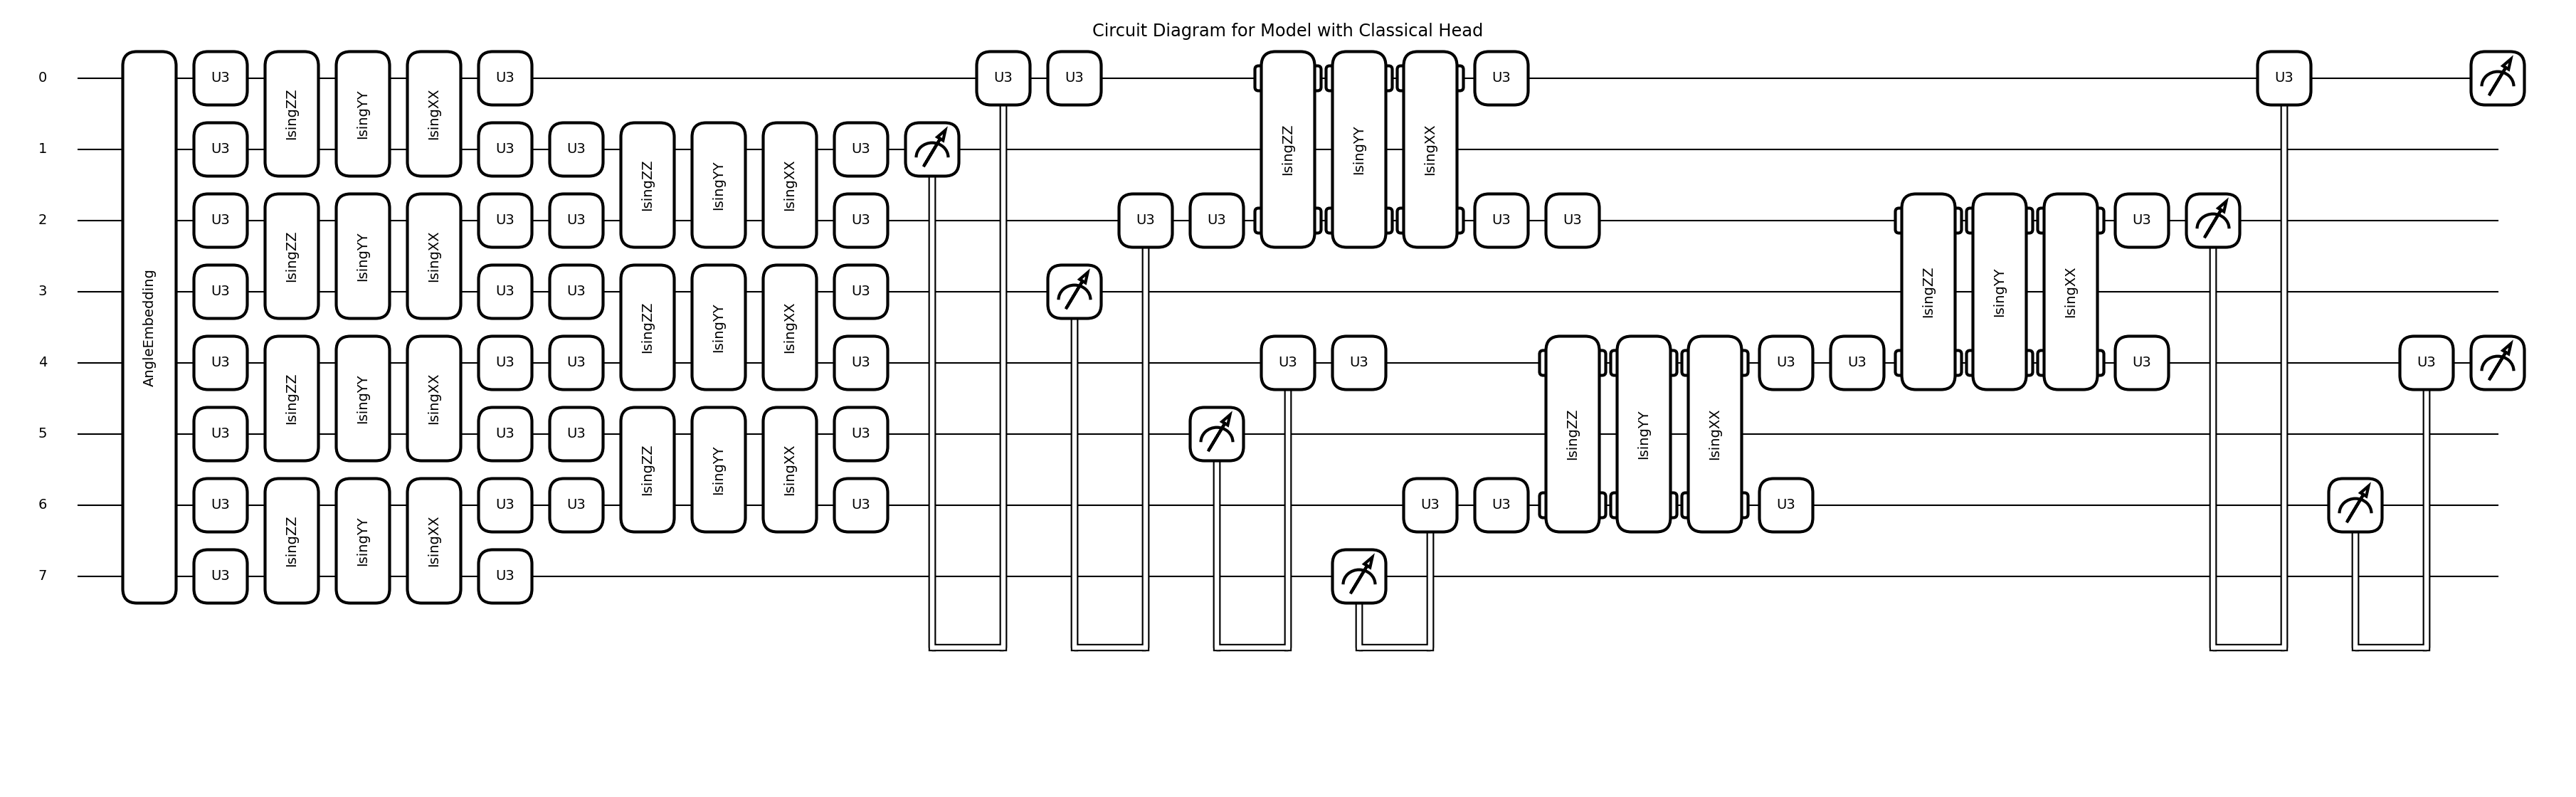

In [29]:
import matplotlib.pyplot as plt

print("Generating visualization for the model with a classical head...")

# Instantiate the new model
vis_model_head = QTCN_ClassicalHead(
    n_qubits=8,
    circuit_depth=2,
    input_dim=input_dim,
    kernel_size=6
)

# Create a QNode from the circuit
vis_qnode_head = qml.QNode(vis_model_head.circuit, vis_model_head.dev, interface="torch")

# Create dummy features and draw the circuit
dummy_features_for_vis = torch.randn(vis_model_head.n_qubits)
fig, ax = qml.draw_mpl(vis_qnode_head)(dummy_features_for_vis)
fig.suptitle("Circuit Diagram for Model with Classical Head", fontsize="xx-large")
plt.show()

In [32]:
def ClassicalHead_Experiment_run(n_qubits, circuit_depth, input_dim, kernel_size, num_epochs=10):
    """
    A dedicated function to run the classical head model experiment.
    """
    print("Running on ", device)
    
    # Instantiate our new model
    model = QTCN_ClassicalHead(n_qubits, circuit_depth, input_dim, kernel_size).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)

    # --- Training and Evaluation Loop ---
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"\nFinal Test Results for Model with Classical Head:")
    print(f"Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}")
    
    return test_loss, test_auc

# --- Execute the experiment ---
print("\n--- Starting Experiment 3: Model with Classical Head ---")
ClassicalHead_Experiment_run(
    n_qubits=8,
    circuit_depth=2,
    input_dim=input_dim,  # Assumes 'input_dim' is loaded from your data
    kernel_size=6,
    num_epochs=10
)


--- Starting Experiment 3: Model with Classical Head ---
Running on  cuda


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Epoch: 01 | Time: 0m 39s
Train Loss: 0.7367, AUC: 0.5107 | Validation Loss: 0.7230, AUC: 0.5684


100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Epoch: 02 | Time: 0m 39s
Train Loss: 0.7091, AUC: 0.5222 | Validation Loss: 0.7022, AUC: 0.5867


100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch: 03 | Time: 0m 38s
Train Loss: 0.6954, AUC: 0.5505 | Validation Loss: 0.6944, AUC: 0.6076


100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


Epoch: 04 | Time: 0m 39s
Train Loss: 0.6904, AUC: 0.6189 | Validation Loss: 0.6915, AUC: 0.6192


100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


Epoch: 05 | Time: 0m 39s
Train Loss: 0.6876, AUC: 0.6534 | Validation Loss: 0.6896, AUC: 0.6279


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch: 06 | Time: 0m 39s
Train Loss: 0.6848, AUC: 0.6756 | Validation Loss: 0.6878, AUC: 0.6420


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Epoch: 07 | Time: 0m 39s
Train Loss: 0.6819, AUC: 0.6771 | Validation Loss: 0.6855, AUC: 0.6485


100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch: 08 | Time: 0m 38s
Train Loss: 0.6782, AUC: 0.6874 | Validation Loss: 0.6823, AUC: 0.6585


100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


Epoch: 09 | Time: 0m 38s
Train Loss: 0.6746, AUC: 0.6876 | Validation Loss: 0.6798, AUC: 0.6751


100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


Epoch: 10 | Time: 0m 39s
Train Loss: 0.6692, AUC: 0.7234 | Validation Loss: 0.6752, AUC: 0.6929


100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Final Test Results for Model with Classical Head:
Test Loss: 0.6717, Test AUC: 0.7374


(0.6717193180864508, 0.7374112075769534)

### QTCN with 3 layers

In [33]:
class QTCN_Deep(nn.Module):
    """
    This is the deepest version, with 3 layers of convolution and pooling.
    - The circuit reduces 8 -> 4 -> 2 -> 1 qubit.
    - The final measurement is on the single remaining qubit.
    """
    def __init__(self, n_qubits, circuit_depth, input_dim, kernel_size):
        super(QTCN_Deep, self).__init__()
        self.n_qubits = n_qubits
        self.circuit_depth = circuit_depth # This will be 3

        # Parameters are now sized for 3 layers
        self.conv_params = nn.Parameter(torch.randn(circuit_depth, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))
        self.dev = qml.device("default.qubit", wires=n_qubits)

        self.input_channels = input_dim[1]
        self.kernel_size = kernel_size
        self.fc = nn.Linear(self.input_channels * self.kernel_size, n_qubits)

    def circuit(self, features):
        """ The quantum circuit with 3 layers of conv+pool. """
        wires = list(range(self.n_qubits))
        qml.AngleEmbedding(features, wires=wires, rotation='Y')
        
        # Loop will run 3 times
        for layer in range(self.circuit_depth):
            self._apply_convolution(self.conv_params[layer], wires)
            self._apply_pooling(self.pool_params[layer], wires)
            wires = wires[::2]
        
        # Correctly measures the single final qubit
        return qml.expval(qml.PauliZ(wires[0]))

    def forward(self, x):
        """ The forward pass logic is identical to the corrected 2-layer model. """
        batch_size, _, time_steps = x.size()
        quantum_circuit = qml.QNode(self.circuit, self.dev, interface="torch")
        
        output_from_windows = []
        for i in range(time_steps - self.kernel_size + 1):
            window = x[:, :, i : i + self.kernel_size].reshape(batch_size, -1)
            reduced_window = self.fc(window)
            output_from_windows.append(quantum_circuit(reduced_window))
            
        output = torch.mean(torch.stack(output_from_windows, dim=1), dim=1)
        return output

    # Helper methods are unchanged
    def _apply_convolution(self, weights, wires):
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

Generating visualization for the Deep 3-Layer model...


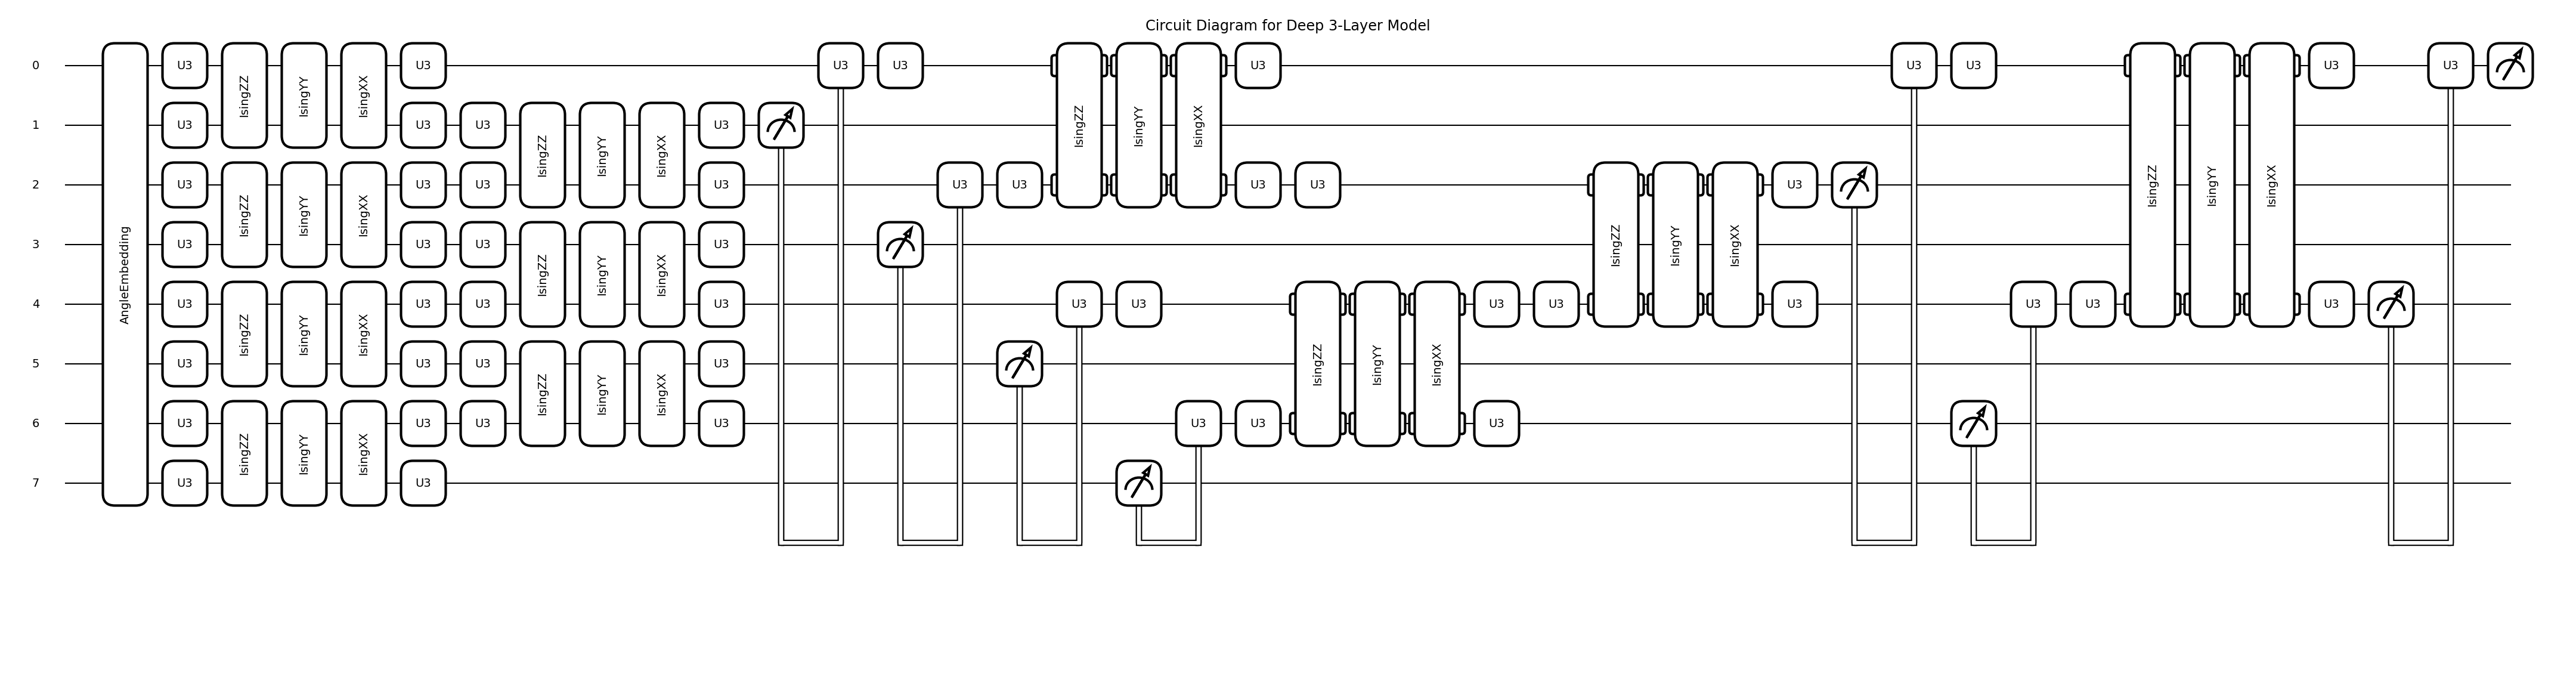

In [34]:
import matplotlib.pyplot as plt

print("Generating visualization for the Deep 3-Layer model...")

# Instantiate the new deep model with circuit_depth=3
vis_model_deep = QTCN_Deep(
    n_qubits=8,
    circuit_depth=3, # Set depth to 3
    input_dim=input_dim,
    kernel_size=6
)

vis_qnode_deep = qml.QNode(vis_model_deep.circuit, vis_model_deep.dev, interface="torch")
dummy_features_for_vis = torch.randn(vis_model_deep.n_qubits)
fig, ax = qml.draw_mpl(vis_qnode_deep)(dummy_features_for_vis)
fig.suptitle("Circuit Diagram for Deep 3-Layer Model", fontsize="xx-large")
plt.show()

In [35]:
def Deep_Experiment_run(n_qubits, circuit_depth, input_dim, kernel_size, num_epochs=10):
    """
    A dedicated function to run the deep 3-layer model experiment.
    """
    print("Running on ", device)
    
    # Instantiate our new deep model
    model = QTCN_Deep(n_qubits, circuit_depth, input_dim, kernel_size).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)

    # --- Training and Evaluation Loop ---
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"\nFinal Test Results for Deep 3-Layer Model:")
    print(f"Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}")
    
    return test_loss, test_auc

# --- Execute the experiment ---
print("\n--- Starting Experiment 4: Deep 3-Layer Model ---")
Deep_Experiment_run(
    n_qubits=8,
    circuit_depth=3, # Set depth to 3
    input_dim=input_dim,
    kernel_size=6,
    num_epochs=10
)


--- Starting Experiment 4: Deep 3-Layer Model ---
Running on  cuda


100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


Epoch: 01 | Time: 0m 42s
Train Loss: 0.6924, AUC: 0.5315 | Validation Loss: 0.6932, AUC: 0.5646


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Epoch: 02 | Time: 0m 44s
Train Loss: 0.6902, AUC: 0.5810 | Validation Loss: 0.6931, AUC: 0.5762


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Epoch: 03 | Time: 0m 44s
Train Loss: 0.6876, AUC: 0.6137 | Validation Loss: 0.6922, AUC: 0.5915


100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


Epoch: 04 | Time: 0m 43s
Train Loss: 0.6845, AUC: 0.6436 | Validation Loss: 0.6906, AUC: 0.6070


100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


Epoch: 05 | Time: 0m 43s
Train Loss: 0.6812, AUC: 0.6671 | Validation Loss: 0.6884, AUC: 0.6247


100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Epoch: 06 | Time: 0m 44s
Train Loss: 0.6774, AUC: 0.6833 | Validation Loss: 0.6856, AUC: 0.6397


100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Epoch: 07 | Time: 0m 43s
Train Loss: 0.6741, AUC: 0.6946 | Validation Loss: 0.6836, AUC: 0.6503


100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


Epoch: 08 | Time: 0m 43s
Train Loss: 0.6704, AUC: 0.7074 | Validation Loss: 0.6803, AUC: 0.6753


100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


Epoch: 09 | Time: 0m 44s
Train Loss: 0.6675, AUC: 0.6981 | Validation Loss: 0.6785, AUC: 0.6810


100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


Epoch: 10 | Time: 0m 43s
Train Loss: 0.6630, AUC: 0.7354 | Validation Loss: 0.6744, AUC: 0.6951


100%|██████████| 11/11 [00:04<00:00,  2.48it/s]


Final Test Results for Deep 3-Layer Model:
Test Loss: 0.6627, Test AUC: 0.7415


(0.6627241156317971, 0.7414759273875297)

## 3-layer QTCN with residual blocks

### CLassical residual block

In [38]:
class QTCN_classical_resid(nn.Module):
    """
    This model adds a classical residual connection to the 3-layer deep QTCN.
    """
    def __init__(self, n_qubits, circuit_depth, input_dim, kernel_size):
        super(QTCN_classical_resid, self).__init__()
        self.n_qubits = n_qubits
        self.circuit_depth = circuit_depth

        # Quantum components
        self.conv_params = nn.Parameter(torch.randn(circuit_depth, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))
        self.dev = qml.device("default.qubit", wires=n_qubits)

        # Classical components
        self.input_channels = input_dim[1]
        self.kernel_size = kernel_size
        self.fc = nn.Linear(self.input_channels * self.kernel_size, n_qubits)
        
        # Add the downsample layer for the residual connection
        self.downsample = nn.Linear(self.input_channels * self.kernel_size, n_qubits)

    def circuit(self, features):
        """ The quantum circuit is the same 3-layer version. """
        wires = list(range(self.n_qubits))
        qml.AngleEmbedding(features, wires=wires, rotation='Y')
        for layer in range(self.circuit_depth):
            self._apply_convolution(self.conv_params[layer], wires)
            self._apply_pooling(self.pool_params[layer], wires)
            wires = wires[::2]
        return qml.expval(qml.PauliZ(wires[0]))

    def forward(self, x):
        """ The forward pass now includes the classical residual logic. """
        batch_size, _, time_steps = x.size()
        quantum_circuit = qml.QNode(self.circuit, self.dev, interface="torch")
        
        output_from_windows = []
        for i in range(time_steps - self.kernel_size + 1):
            # Main path
            window = x[:, :, i : i + self.kernel_size].reshape(batch_size, -1)
            reduced_window = self.fc(window)
            
            # Residual path
            residual_input = x[:, :, -(self.kernel_size):].reshape(batch_size, -1)
            residual = self.downsample(residual_input)

            # Add residual to the main path before the quantum circuit
            quantum_input = reduced_window + residual
            output_from_windows.append(quantum_circuit(quantum_input))
            
        output = torch.mean(torch.stack(output_from_windows, dim=1), dim=1)
        return output

    # Helper methods are unchanged
    def _apply_convolution(self, weights, wires):
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

Generating visualization for the model with a Classical Residual Block...


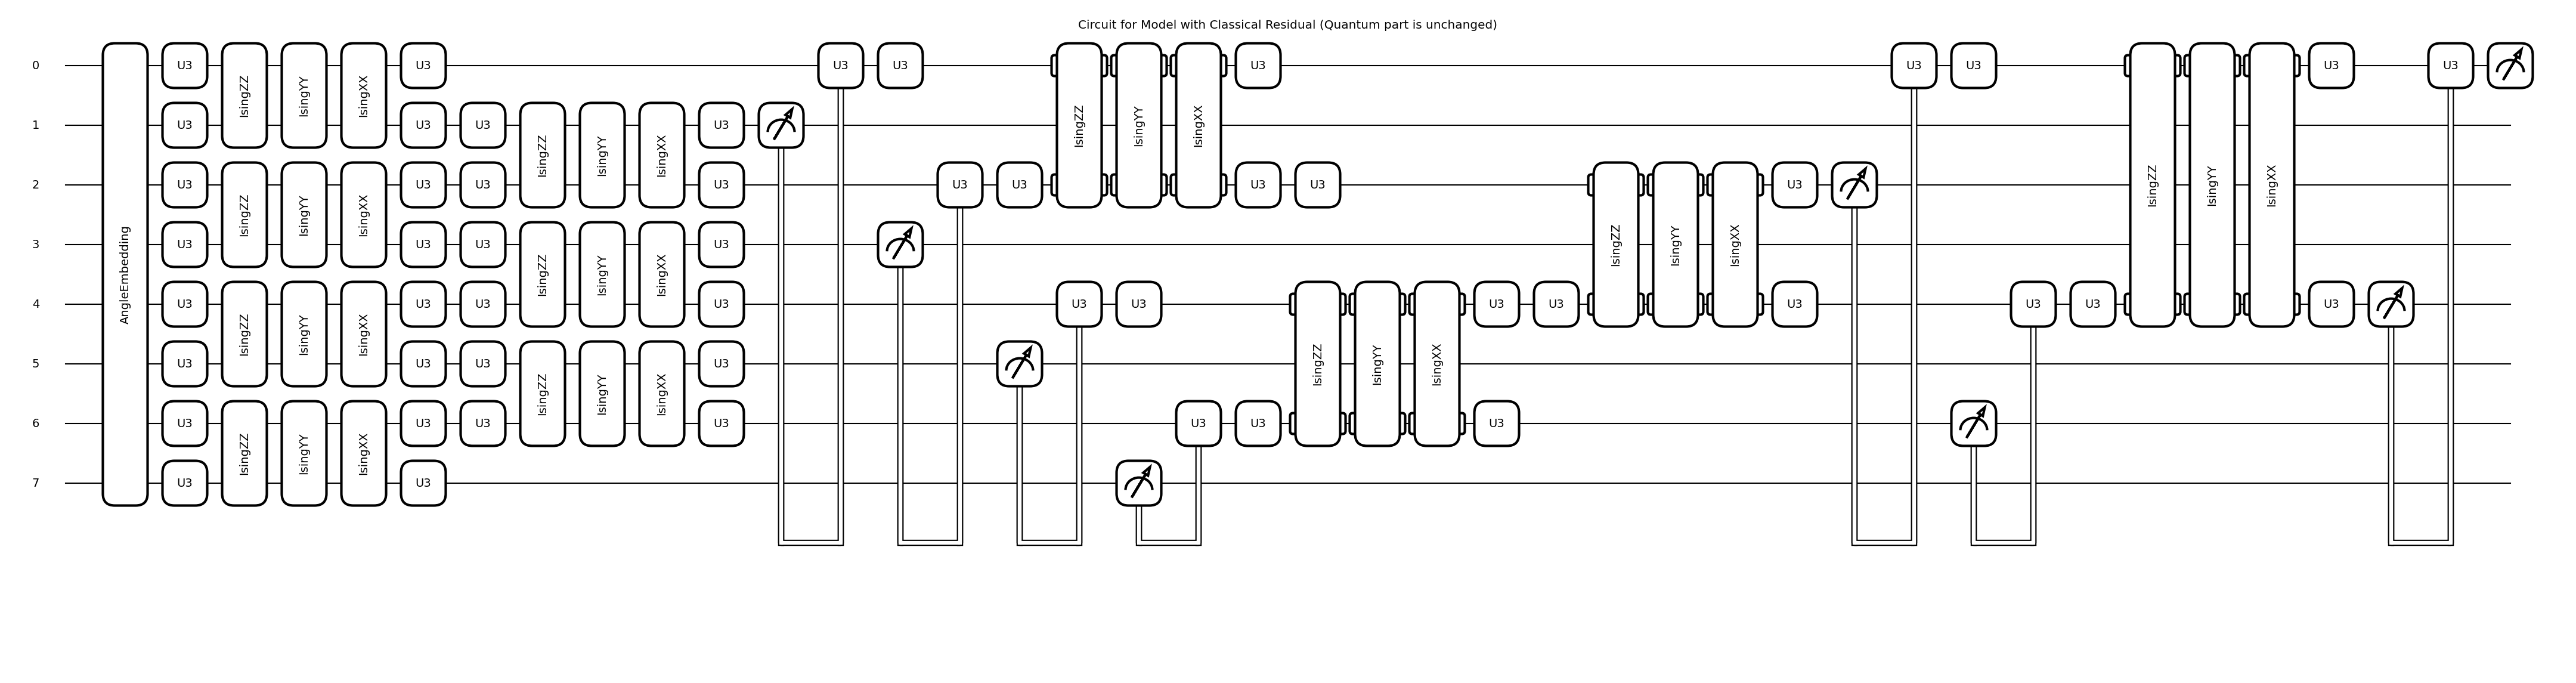

In [39]:
import matplotlib.pyplot as plt

print("Generating visualization for the model with a Classical Residual Block...")

# Instantiate the new model
vis_model_resid = QTCN_classical_resid(
    n_qubits=8,
    circuit_depth=3,
    input_dim=input_dim,
    kernel_size=6
)

vis_qnode_resid = qml.QNode(vis_model_resid.circuit, vis_model_resid.dev, interface="torch")
dummy_features_for_vis = torch.randn(vis_model_resid.n_qubits)
fig, ax = qml.draw_mpl(vis_qnode_resid)(dummy_features_for_vis)
fig.suptitle("Circuit for Model with Classical Residual (Quantum part is unchanged)", fontsize="x-large")
plt.show()

In [40]:
def ClassicalResid_Experiment_run(n_qubits, circuit_depth, input_dim, kernel_size, num_epochs=10):
    """
    A dedicated function to run the classical residual model experiment.
    """
    print("Running on ", device)
    
    # Instantiate our new model
    model = QTCN_classical_resid(n_qubits, circuit_depth, input_dim, kernel_size).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)

    # --- Training and Evaluation Loop ---
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"\nFinal Test Results for Model with Classical Residual:")
    print(f"Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}")
    
    return test_loss, test_auc

# --- Execute the experiment ---
print("\n--- Starting Experiment 5: Model with Classical Residual Block ---")
ClassicalResid_Experiment_run(
    n_qubits=8,
    circuit_depth=3,
    input_dim=input_dim,
    kernel_size=6,
    num_epochs=10
)


--- Starting Experiment 5: Model with Classical Residual Block ---
Running on  cuda


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Epoch: 01 | Time: 0m 44s
Train Loss: 0.6925, AUC: 0.5198 | Validation Loss: 0.6917, AUC: 0.6287


100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Epoch: 02 | Time: 0m 44s
Train Loss: 0.6874, AUC: 0.6411 | Validation Loss: 0.6894, AUC: 0.6453


100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Epoch: 03 | Time: 0m 44s
Train Loss: 0.6807, AUC: 0.6673 | Validation Loss: 0.6857, AUC: 0.6455


100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Epoch: 04 | Time: 0m 44s
Train Loss: 0.6729, AUC: 0.6882 | Validation Loss: 0.6808, AUC: 0.6540


100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


Epoch: 05 | Time: 0m 44s
Train Loss: 0.6646, AUC: 0.7125 | Validation Loss: 0.6768, AUC: 0.6706


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Epoch: 06 | Time: 0m 44s
Train Loss: 0.6557, AUC: 0.7298 | Validation Loss: 0.6733, AUC: 0.6822


100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Epoch: 07 | Time: 0m 44s
Train Loss: 0.6481, AUC: 0.7539 | Validation Loss: 0.6657, AUC: 0.7002


100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


Epoch: 08 | Time: 0m 44s
Train Loss: 0.6410, AUC: 0.7685 | Validation Loss: 0.6615, AUC: 0.7116


100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


Epoch: 09 | Time: 0m 44s
Train Loss: 0.6336, AUC: 0.7808 | Validation Loss: 0.6564, AUC: 0.7160


100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Epoch: 10 | Time: 0m 43s
Train Loss: 0.6298, AUC: 0.7814 | Validation Loss: 0.6537, AUC: 0.7190


100%|██████████| 11/11 [00:04<00:00,  2.59it/s]


Final Test Results for Model with Classical Residual:
Test Loss: 0.6331, Test AUC: 0.7545


(0.6331268494779413, 0.7544593528018942)

### QTCN with the original quantum residual blocks

In [41]:
class QTCN_quantum_resid(nn.Module):
    """
    This model integrates a quantum residual block into each layer
    of the 3-layer deep QTCN.
    """
    def __init__(self, n_qubits, circuit_depth, input_dim, kernel_size):
        super(QTCN_quantum_resid, self).__init__()
        # We need n_qubits for processing + 1 for the ancilla
        self.n_main_qubits = n_qubits
        self.circuit_depth = circuit_depth
        self.ancilla_wire = self.n_main_qubits
        
        # Quantum parameters
        self.conv_params = nn.Parameter(torch.randn(circuit_depth, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))
        
        # Add learnable residual parameters, one for each layer
        self.residual_params = nn.Parameter(torch.randn(circuit_depth, 1))
        
        # Device must accommodate the ancilla qubit
        self.dev = qml.device("default.qubit", wires=n_qubits + 1)

        # Classical components
        self.input_channels = input_dim[1]
        self.kernel_size = kernel_size
        self.fc = nn.Linear(self.input_channels * self.kernel_size, n_qubits)

    def _controlled_convolution(self, weights, wires):
        """ The convolution operation that will be controlled by the ancilla. """
        self._apply_convolution(weights, wires)

    def circuit(self, features):
        main_wires = list(range(self.n_main_qubits))
        qml.AngleEmbedding(features, wires=main_wires, rotation='Y')
        
        for layer in range(self.circuit_depth):
            # 1. Quantum Switch: Apply RY rotation to ancilla
            qml.RY(self.residual_params[layer][0], wires=self.ancilla_wire)
            
            # 2. Controlled Operation: Apply convolution controlled by ancilla
            qml.ctrl(self._controlled_convolution, control=self.ancilla_wire)(self.conv_params[layer], main_wires)
            
            # 3. Reset: Uncompute the ancilla rotation
            qml.RY(-self.residual_params[layer][0], wires=self.ancilla_wire)
            
            # Pooling is applied unconditionally
            self._apply_pooling(self.pool_params[layer], main_wires)
            main_wires = main_wires[::2]
            
        return qml.expval(qml.PauliZ(main_wires[0]))

    def forward(self, x):
        batch_size, _, time_steps = x.size()
        quantum_circuit = qml.QNode(self.circuit, self.dev, interface="torch")
        
        output_from_windows = []
        for i in range(time_steps - self.kernel_size + 1):
            window = x[:, :, i : i + self.kernel_size].reshape(batch_size, -1)
            reduced_window = self.fc(window)
            output_from_windows.append(quantum_circuit(reduced_window))
            
        output = torch.mean(torch.stack(output_from_windows, dim=1), dim=1)
        return output

    # Helper methods are unchanged
    def _apply_convolution(self, weights, wires):
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

Generating visualization for the model with Quantum Residual Blocks...


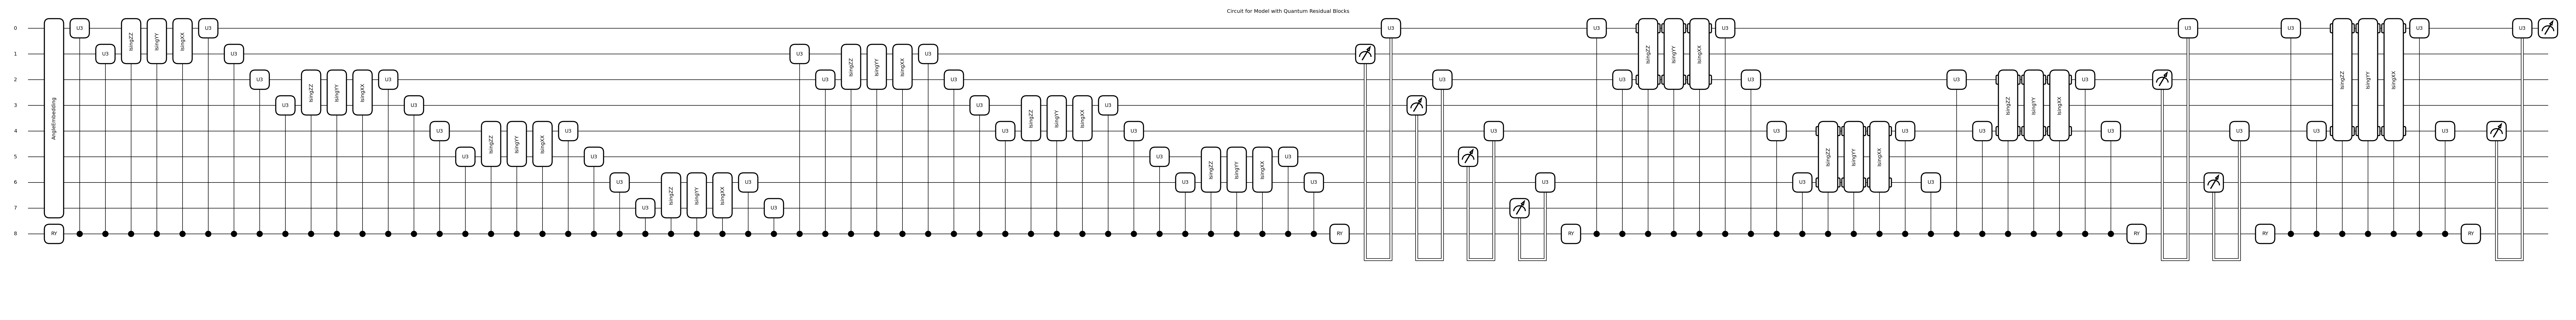

In [42]:
import matplotlib.pyplot as plt

print("Generating visualization for the model with Quantum Residual Blocks...")

# Instantiate the new model
vis_model_qresid = QTCN_quantum_resid(
    n_qubits=8,
    circuit_depth=3,
    input_dim=input_dim,
    kernel_size=6
)

vis_qnode_qresid = qml.QNode(vis_model_qresid.circuit, vis_model_qresid.dev, interface="torch")
dummy_features_for_vis = torch.randn(vis_model_qresid.n_main_qubits)
fig, ax = qml.draw_mpl(vis_qnode_qresid)(dummy_features_for_vis)
fig.suptitle("Circuit for Model with Quantum Residual Blocks", fontsize="x-large")
plt.show()

In [43]:
def QuantumResid_Experiment_run(n_qubits, circuit_depth, input_dim, kernel_size, num_epochs=10):
    """
    A dedicated function to run the quantum residual model experiment.
    """
    print("Running on ", device)
    
    # Instantiate our new model
    model = QTCN_quantum_resid(n_qubits, circuit_depth, input_dim, kernel_size).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)

    # --- Training and Evaluation Loop ---
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"\nFinal Test Results for Model with Quantum Residual:")
    print(f"Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}")
    
    return test_loss, test_auc

# --- Execute the experiment ---
print("\n--- Starting Experiment 6: Model with Quantum Residual Blocks ---")
QuantumResid_Experiment_run(
    n_qubits=8,
    circuit_depth=3,
    input_dim=input_dim,
    kernel_size=6,
    num_epochs=10
)


--- Starting Experiment 6: Model with Quantum Residual Blocks ---
Running on  cuda


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Epoch: 01 | Time: 1m 11s
Train Loss: 0.7442, AUC: 0.5253 | Validation Loss: 0.7364, AUC: 0.5651


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Epoch: 02 | Time: 1m 12s
Train Loss: 0.7225, AUC: 0.5328 | Validation Loss: 0.7176, AUC: 0.5622


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Epoch: 03 | Time: 1m 14s
Train Loss: 0.7046, AUC: 0.5640 | Validation Loss: 0.7051, AUC: 0.5664


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Epoch: 04 | Time: 1m 12s
Train Loss: 0.6941, AUC: 0.5879 | Validation Loss: 0.6978, AUC: 0.5715


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch: 05 | Time: 1m 10s
Train Loss: 0.6880, AUC: 0.6062 | Validation Loss: 0.6938, AUC: 0.5830


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch: 06 | Time: 1m 9s
Train Loss: 0.6844, AUC: 0.6232 | Validation Loss: 0.6910, AUC: 0.5989


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Epoch: 07 | Time: 1m 10s
Train Loss: 0.6816, AUC: 0.6422 | Validation Loss: 0.6887, AUC: 0.6159


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Epoch: 08 | Time: 1m 9s
Train Loss: 0.6788, AUC: 0.6595 | Validation Loss: 0.6864, AUC: 0.6366


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch: 09 | Time: 1m 9s
Train Loss: 0.6755, AUC: 0.6783 | Validation Loss: 0.6840, AUC: 0.6447


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch: 10 | Time: 1m 9s
Train Loss: 0.6730, AUC: 0.6890 | Validation Loss: 0.6818, AUC: 0.6555


100%|██████████| 11/11 [00:08<00:00,  1.27it/s]


Final Test Results for Model with Quantum Residual:
Test Loss: 0.6775, Test AUC: 0.6867


(0.6775250218131326, 0.6867008681925808)

### QTCN with quantum residual block from Wen et al. (2024)

### Wen, Jingwei, Zhiguo Huang, Dunbo Cai, and Ling Qian. “Enhancing the Expressivity of Quantum Neural Networks with Residual Connections.” Communications Physics 7, no. 1 (July 6, 2024): 220. https://doi.org/10.1038/s42005-024-01719-1.

How the Paper's Quantum Residual Block Works
The key idea of this method is to create a superposition of the identity (the skip connection) and the transformation (the convolution). Unlike the previous quantum residual block which learned a probability of skipping, this method deterministically creates a state that is a linear combination of the "skipped" state and the "transformed" state.

It works in three steps for each layer, as described in the paper :

1. Create a Superposition: A Hadamard gate is applied to an auxiliary "ancilla" qubit. This puts the ancilla in an equal superposition of |0⟩ and |1⟩.

2. Apply a Controlled Transformation: The main convolutional block (F) is applied to the primary qubits, but this operation is made conditional on the ancilla being in the |1⟩ state using a qml.ctrl gate.
If the ancilla is |0⟩, the primary qubits are unchanged (the identity path x).
If the ancilla is |1⟩, the primary qubits are transformed by the convolution (the transformation path F(x)).

3. Interference: A second Hadamard gate is applied to the ancilla. This causes the two paths to interfere. The final state of the primary qubits, conditioned on the ancilla being measured as |0⟩, is proportional to the desired residual state (F(x) + x)|ψ⟩. The circuit essentially forces the computation into a subspace that represents this sum.

This approach is a more faithful quantum analogue of the classical residual connection F(x) + x.

In [44]:
class QTCN_Paper_Resid(nn.Module):
    """
    This model implements the quantum residual connection from the paper
    "Enhancing the expressivity of quantum neural networks..."
    using an ancilla and Hadamard gates.
    """
    def __init__(self, n_qubits, circuit_depth, input_dim, kernel_size):
        super(QTCN_Paper_Resid, self).__init__()
        self.n_main_qubits = n_qubits
        self.circuit_depth = circuit_depth
        self.ancilla_wire = self.n_main_qubits
        
        # Quantum parameters
        self.conv_params = nn.Parameter(torch.randn(circuit_depth, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))
        
        # Device must accommodate the ancilla qubit
        self.dev = qml.device("default.qubit", wires=n_qubits + 1)

        # Classical components
        self.input_channels = input_dim[1]
        self.kernel_size = kernel_size
        self.fc = nn.Linear(self.input_channels * self.kernel_size, n_qubits)

    def _controlled_convolution(self, weights, wires):
        """ The convolution operation that will be controlled by the ancilla. """
        self._apply_convolution(weights, wires)

    def circuit(self, features):
        main_wires = list(range(self.n_main_qubits))
        qml.AngleEmbedding(features, wires=main_wires, rotation='Y')
        
        for layer in range(self.circuit_depth):
            # 1. First Hadamard on ancilla
            qml.Hadamard(wires=self.ancilla_wire)
            
            # 2. Controlled Convolution
            qml.ctrl(self._controlled_convolution, control=self.ancilla_wire)(self.conv_params[layer], main_wires)
            
            # 3. Second Hadamard on ancilla
            qml.Hadamard(wires=self.ancilla_wire)
            
            # Pooling is applied unconditionally to the main qubits
            self._apply_pooling(self.pool_params[layer], main_wires)
            main_wires = main_wires[::2]
            
        return qml.expval(qml.PauliZ(main_wires[0]))

    def forward(self, x):
        batch_size, _, time_steps = x.size()
        quantum_circuit = qml.QNode(self.circuit, self.dev, interface="torch")
        
        output_from_windows = []
        for i in range(time_steps - self.kernel_size + 1):
            window = x[:, :, i : i + self.kernel_size].reshape(batch_size, -1)
            reduced_window = self.fc(window)
            output_from_windows.append(quantum_circuit(reduced_window))
            
        output = torch.mean(torch.stack(output_from_windows, dim=1), dim=1)
        return output

    # Helper methods are unchanged
    def _apply_convolution(self, weights, wires):
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

Generating visualization for the model with the paper's Quantum Residual Block...


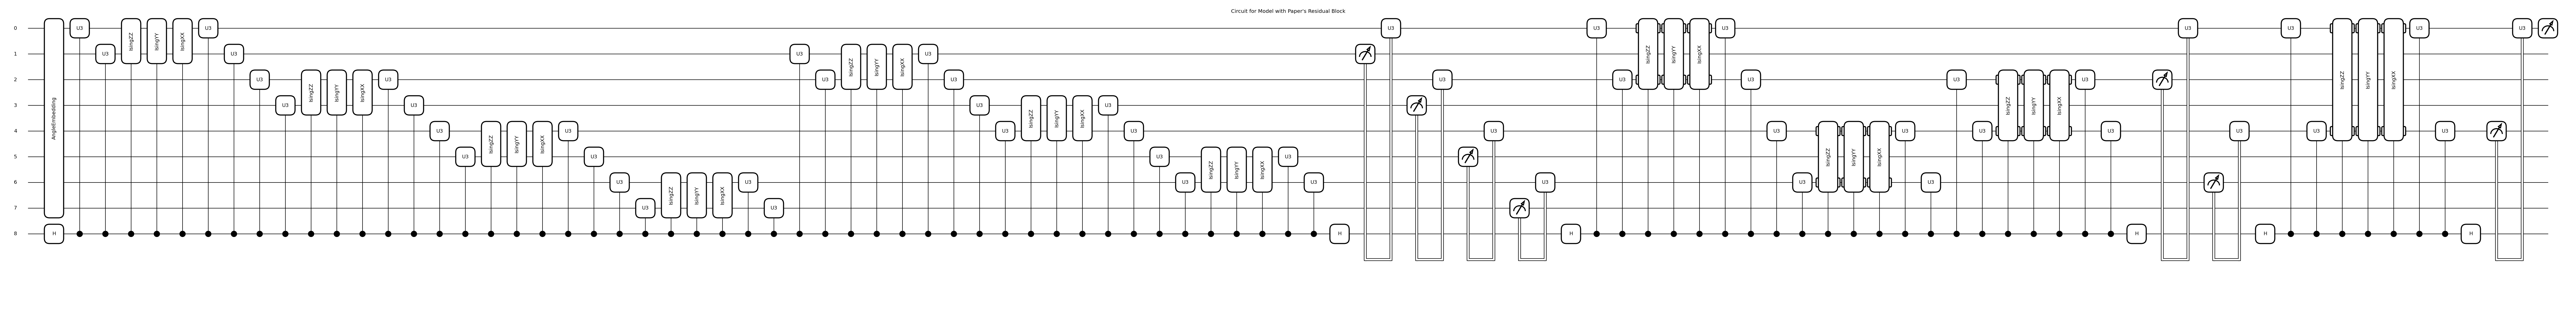

In [45]:
import matplotlib.pyplot as plt

print("Generating visualization for the model with the paper's Quantum Residual Block...")

# Instantiate the new model
vis_model_paper_resid = QTCN_Paper_Resid(
    n_qubits=8,
    circuit_depth=3,
    input_dim=input_dim,
    kernel_size=6
)

vis_qnode_paper_resid = qml.QNode(vis_model_paper_resid.circuit, vis_model_paper_resid.dev, interface="torch")
dummy_features_for_vis = torch.randn(vis_model_paper_resid.n_main_qubits)
fig, ax = qml.draw_mpl(vis_qnode_paper_resid)(dummy_features_for_vis)
fig.suptitle("Circuit for Model with Paper's Residual Block", fontsize="x-large")
plt.show()

In [46]:
def PaperResid_Experiment_run(n_qubits, circuit_depth, input_dim, kernel_size, num_epochs=10):
    """
    A dedicated function to run the quantum residual model from the paper.
    """
    print("Running on ", device)
    
    # Instantiate our new model
    model = QTCN_Paper_Resid(n_qubits, circuit_depth, input_dim, kernel_size).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)

    # --- Training and Evaluation Loop ---
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"\nFinal Test Results for Model with Paper's Residual Block:")
    print(f"Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}")
    
    return test_loss, test_auc

# --- Execute the experiment ---
print("\n--- Starting Experiment 7: Model with Paper's Quantum Residual Block ---")
PaperResid_Experiment_run(
    n_qubits=8,
    circuit_depth=3,
    input_dim=input_dim,
    kernel_size=6,
    num_epochs=10
)


--- Starting Experiment 7: Model with Paper's Quantum Residual Block ---
Running on  cuda


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Epoch: 01 | Time: 1m 11s
Train Loss: 0.7077, AUC: 0.5143 | Validation Loss: 0.7023, AUC: 0.5834


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch: 02 | Time: 1m 7s
Train Loss: 0.6973, AUC: 0.5464 | Validation Loss: 0.6966, AUC: 0.5876


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Epoch: 03 | Time: 1m 7s
Train Loss: 0.6932, AUC: 0.5967 | Validation Loss: 0.6945, AUC: 0.5876


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Epoch: 04 | Time: 1m 7s
Train Loss: 0.6916, AUC: 0.6081 | Validation Loss: 0.6929, AUC: 0.6006


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Epoch: 05 | Time: 1m 8s
Train Loss: 0.6899, AUC: 0.6221 | Validation Loss: 0.6919, AUC: 0.6047


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


Epoch: 06 | Time: 1m 8s
Train Loss: 0.6883, AUC: 0.6289 | Validation Loss: 0.6910, AUC: 0.6083


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Epoch: 07 | Time: 1m 9s
Train Loss: 0.6864, AUC: 0.6354 | Validation Loss: 0.6895, AUC: 0.6238


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Epoch: 08 | Time: 1m 11s
Train Loss: 0.6841, AUC: 0.6485 | Validation Loss: 0.6888, AUC: 0.6262


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Epoch: 09 | Time: 1m 7s
Train Loss: 0.6828, AUC: 0.6584 | Validation Loss: 0.6871, AUC: 0.6349


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Epoch: 10 | Time: 1m 8s
Train Loss: 0.6802, AUC: 0.6721 | Validation Loss: 0.6859, AUC: 0.6421


100%|██████████| 11/11 [00:08<00:00,  1.28it/s]


Final Test Results for Model with Paper's Residual Block:
Test Loss: 0.6856, Test AUC: 0.6759


(0.6855853308330883, 0.6758879242304656)

### QTCN with quantum residual block from Yang et al. (2025)

### Yang, Qingchuan, Wenjun Zhang, and Lianfu Wei. “A Quantum Residual Attention Neural Network for High-Precision Material Property Prediction.” Quantum Information Processing 24, no. 2 (February 10, 2025): 53. https://doi.org/10.1007/s11128-025-04670-4.


How the Quantum Residual Attention Block Works
Instead of creating a simple skip connection, the QRAL from the paper  aims to create a richer, more complex interaction between the data qubits and an auxiliary qubit. It uses the ancilla to gather and redistribute information among the data qubits, creating a form of "attention." The "residual" aspect comes from this deep sharing of information across the circuit via the ancilla.

Based on the paper's description and its circuit diagram (Fig. 1b), the process for each layer is as follows:

1. Feature Enhancement: First, RX gates are applied to all data qubits to map the features into a complex domain.

2. Information Gathering (Attention): A "star-connected" CNOT gate pattern is used, where each data qubit acts as a control for a CNOT gate targeting the single ancilla qubit. This entangles all data qubits with the ancilla, effectively focusing information from the entire data register onto it.

3. Transformation: A learnable RY rotation is applied to the ancilla, transforming the collective information it just gathered.

4. Information Distribution: The star-connected CNOT pattern is applied again. This uses the new state of the ancilla to influence all the data qubits, distributing the processed "attended" information back.

5. Final Feature Transformation: A final set of learnable RY gates is applied to each data qubit.

This entire block creates a parameterized, non-local interaction across all qubits, mediated by the ancilla, which is a much more intricate operation than the simpler skip connections.

In [50]:
class QTCN_Attention_Resid(nn.Module):
    """
    This model implements the Quantum Residual Attention Layer (QRAL)
    from the paper "A quantum residual attention neural network..."
    """
    def __init__(self, n_qubits, circuit_depth, input_dim, kernel_size):
        super(QTCN_Attention_Resid, self).__init__()
        self.n_main_qubits = n_qubits
        self.circuit_depth = circuit_depth
        self.ancilla_wire = self.n_main_qubits

        # We need parameters for each attention block in each layer
        # [Rx_params, Ry_ancilla_param, Ry_params] for each layer
        self.attention_params = nn.Parameter(torch.randn(circuit_depth, 2 * n_qubits + 1))
        
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))
        self.dev = qml.device("default.qubit", wires=n_qubits + 1)

        self.input_channels = input_dim[1]
        self.kernel_size = kernel_size
        self.fc = nn.Linear(self.input_channels * self.kernel_size, n_qubits)

    def _apply_attention_block(self, params, wires):
        """ Applies the QRAL block based on the paper's diagram. """
        n_wires = len(wires)
        rx_params = params[:n_wires]
        ry_ancilla_param = params[n_wires]
        ry_params = params[n_wires+1:]

        # 1. Feature Enhancement
        for i, wire in enumerate(wires):
            qml.RX(rx_params[i], wires=wire)

        # 2. Information Gathering
        for wire in wires:
            qml.CNOT(wires=[wire, self.ancilla_wire])

        # 3. Transformation
        qml.RY(ry_ancilla_param, wires=self.ancilla_wire)

        # 4. Information Distribution
        for wire in wires:
            qml.CNOT(wires=[wire, self.ancilla_wire])

        # 5. Final Feature Transformation
        for i, wire in enumerate(wires):
            qml.RY(ry_params[i], wires=wire)

    def circuit(self, features):
        main_wires = list(range(self.n_main_qubits))
        qml.AngleEmbedding(features, wires=main_wires, rotation='Y')
        
        for layer in range(self.circuit_depth):
            # Apply the attention block instead of the standard convolution
            self._apply_attention_block(self.attention_params[layer], main_wires)
            
            # Pooling is applied unconditionally to the main qubits
            self._apply_pooling(self.pool_params[layer], main_wires)
            main_wires = main_wires[::2]
            
        return qml.expval(qml.PauliZ(main_wires[0]))

    def forward(self, x):
        batch_size, _, time_steps = x.size()
        quantum_circuit = qml.QNode(self.circuit, self.dev, interface="torch")
        
        output_from_windows = []
        for i in range(time_steps - self.kernel_size + 1):
            window = x[:, :, i : i + self.kernel_size].reshape(batch_size, -1)
            reduced_window = self.fc(window)
            output_from_windows.append(quantum_circuit(reduced_window))
            
        output = torch.mean(torch.stack(output_from_windows, dim=1), dim=1)
        return output

    # We only need the pooling helper method now
    def _apply_pooling(self, pool_weights, wires):
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

Generating visualization for the model with the Attention Residual Block...


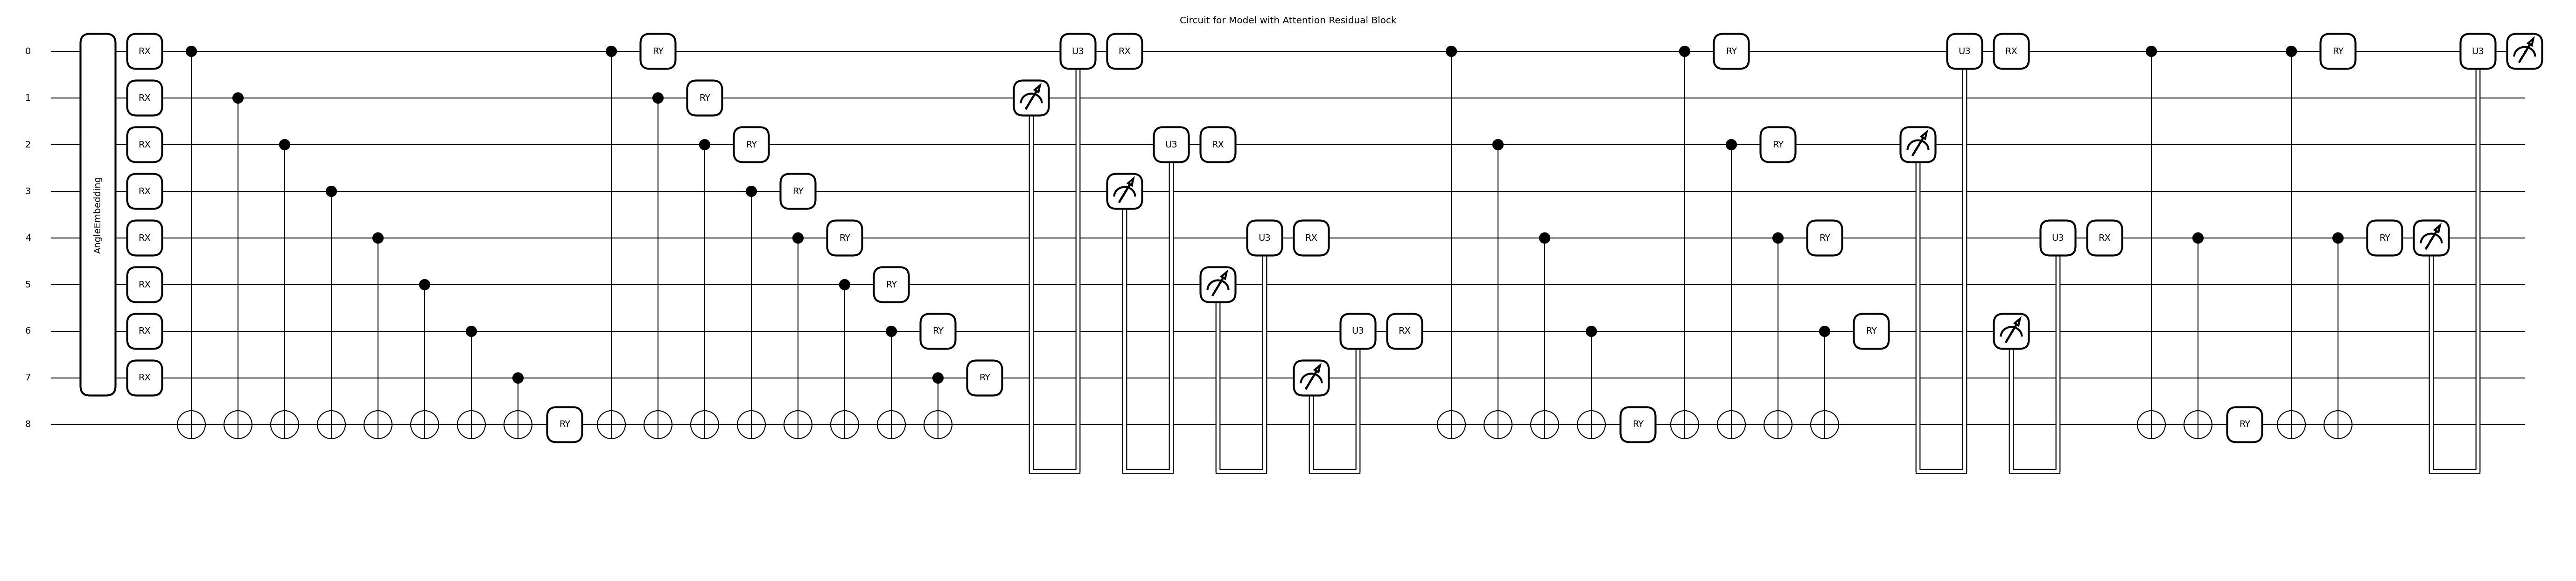

In [51]:
import matplotlib.pyplot as plt

print("Generating visualization for the model with the Attention Residual Block...")

# Instantiate the new model
vis_model_attention = QTCN_Attention_Resid(
    n_qubits=8,
    circuit_depth=3,
    input_dim=input_dim,
    kernel_size=6
)

vis_qnode_attention = qml.QNode(vis_model_attention.circuit, vis_model_attention.dev, interface="torch")
dummy_features_for_vis = torch.randn(vis_model_attention.n_main_qubits)
fig, ax = qml.draw_mpl(vis_qnode_attention)(dummy_features_for_vis)
fig.suptitle("Circuit for Model with Attention Residual Block", fontsize="x-large")
plt.show()

In [49]:
def AttentionResid_Experiment_run(n_qubits, circuit_depth, input_dim, kernel_size, num_epochs=10):
    """
    A dedicated function to run the quantum attention residual model experiment.
    """
    print("Running on ", device)
    
    # Instantiate our new model
    model = QTCN_Attention_Resid(n_qubits, circuit_depth, input_dim, kernel_size).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)

    # --- Training and Evaluation Loop ---
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"\nFinal Test Results for Model with Attention Residual Block:")
    print(f"Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}")
    
    return test_loss, test_auc

# --- Execute the experiment ---
print("\n--- Starting Experiment 8: Model with Attention-Based Quantum Residual Block ---")
AttentionResid_Experiment_run(
    n_qubits=8,
    circuit_depth=3,
    input_dim=input_dim,
    kernel_size=6,
    num_epochs=10
)


--- Starting Experiment 8: Model with Attention-Based Quantum Residual Block ---
Running on  cuda


100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


Epoch: 01 | Time: 0m 26s
Train Loss: 0.6936, AUC: 0.5166 | Validation Loss: 0.6934, AUC: 0.5888


100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


Epoch: 02 | Time: 0m 26s
Train Loss: 0.6914, AUC: 0.6410 | Validation Loss: 0.6931, AUC: 0.5890


100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


Epoch: 03 | Time: 0m 26s
Train Loss: 0.6893, AUC: 0.6439 | Validation Loss: 0.6923, AUC: 0.6013


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


Epoch: 04 | Time: 0m 26s
Train Loss: 0.6872, AUC: 0.6600 | Validation Loss: 0.6912, AUC: 0.6063


100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


Epoch: 05 | Time: 0m 26s
Train Loss: 0.6846, AUC: 0.6722 | Validation Loss: 0.6899, AUC: 0.6225


100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


Epoch: 06 | Time: 0m 26s
Train Loss: 0.6817, AUC: 0.6857 | Validation Loss: 0.6880, AUC: 0.6306


100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


Epoch: 07 | Time: 0m 26s
Train Loss: 0.6791, AUC: 0.6886 | Validation Loss: 0.6861, AUC: 0.6421


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


Epoch: 08 | Time: 0m 26s
Train Loss: 0.6764, AUC: 0.6971 | Validation Loss: 0.6838, AUC: 0.6513


100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


Epoch: 09 | Time: 0m 26s
Train Loss: 0.6736, AUC: 0.7072 | Validation Loss: 0.6825, AUC: 0.6616


100%|██████████| 10/10 [00:02<00:00,  4.10it/s]


Epoch: 10 | Time: 0m 26s
Train Loss: 0.6708, AUC: 0.7151 | Validation Loss: 0.6801, AUC: 0.6688


100%|██████████| 11/11 [00:02<00:00,  4.04it/s]


Final Test Results for Model with Attention Residual Block:
Test Loss: 0.6722, Test AUC: 0.7309


(0.6721954399889166, 0.7309392265193371)

### QTCN with quantum residual block: Entanglement-Swap Residual Connection (Gemini)

The core idea here is to create the residual connection not by "skipping" an operation, but by swapping a learnable amount of information between the "identity" path and the "transformed" path. We'll use entanglement to do this in a purely quantum way, without ancilla qubits.

How it Works
1. Duplicate and Entangle: For each layer, we double the number of qubits. The first half (data_wires) receives the input features. The second half (resid_wires) is initialized to the zero state. We then create maximum entanglement (a Bell state) between each corresponding pair of data and residual qubits using a Hadamard and a CNOT gate.

2. Transform Path: The main convolutional block (F) is applied only to the data_wires. The resid_wires are untouched, representing the "identity" path.

3. Learnable Information Swap: After the convolution, we apply a single, learnable CRY (controlled-RY) rotation between each pair of data and residual qubits. The angle of this rotation is a trainable parameter.
* If the angle is 0, no information is swapped, and the residual qubits remain in their original state (the identity path).
* If the angle is π, a full swap occurs.
* By learning an angle between 0 and π, the model learns the optimal "amount" of the transformation to mix with the identity.

4. Continue with Residuals: We then discard the data_wires and continue the next layer's computation using only the resid_wires, which now hold the new mixed state.

This method creates a "soft" residual connection where the model itself learns the degree of the skip connection for each layer.

In [52]:
class QTCN_Entanglement_Resid(nn.Module):
    """
    Implements a residual connection via a learnable entanglement swap.
    """
    def __init__(self, n_qubits, circuit_depth, input_dim, kernel_size):
        super(QTCN_Entanglement_Resid, self).__init__()
        self.n_main_qubits = n_qubits
        self.circuit_depth = circuit_depth
        
        # We need 2x the qubits for the swap, but the device is defined inside the QNode
        
        # Quantum Parameters
        self.conv_params = nn.Parameter(torch.randn(circuit_depth, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))
        # Add a learnable swap angle for each layer
        self.swap_angles = nn.Parameter(torch.randn(circuit_depth, 1))
        
        # Classical components
        self.input_channels = input_dim[1]
        self.kernel_size = kernel_size
        self.fc = nn.Linear(self.input_channels * self.kernel_size, n_qubits)

    def circuit(self, features):
        # The circuit is dynamically sized based on the layer
        # This setup is more complex, so we define QNodes inside the forward pass
        pass # The main logic will be in the forward pass

    def forward(self, x):
        batch_size, _, time_steps = x.size()
        
        output_from_windows = []
        for i in range(time_steps - self.kernel_size + 1):
            window = x[:, :, i : i + self.kernel_size].reshape(batch_size, -1)
            reduced_window = self.fc(window)
            
            # --- Main Logic for Entanglement Swap ---
            
            # Start with the initial features
            current_features = reduced_window
            
            for layer in range(self.circuit_depth):
                n_current_qubits = current_features.shape[1]
                dev = qml.device("default.qubit", wires=2 * n_current_qubits)

                @qml.qnode(dev, interface="torch")
                def quantum_layer(layer_features, conv_p, pool_p, swap_angle):
                    data_wires = list(range(n_current_qubits))
                    resid_wires = list(range(n_current_qubits, 2 * n_current_qubits))
                    
                    # 1. Encode data and create entangled pairs
                    qml.AngleEmbedding(layer_features, wires=data_wires, rotation='Y')
                    for d, r in zip(data_wires, resid_wires):
                        qml.Hadamard(wires=d)
                        qml.CNOT(wires=[d, r])
                        
                    # 2. Apply convolution ONLY to data wires
                    self._apply_convolution(conv_p, data_wires)
                    
                    # 3. Learnable Information Swap
                    for d, r in zip(data_wires, resid_wires):
                        qml.CRY(swap_angle, wires=[d, r])
                    
                    # 4. Pooling is applied to the residual wires
                    self._apply_pooling(pool_p, resid_wires)
                    
                    # We will measure all remaining residual qubits and average them
                    remaining_resid_wires = resid_wires[::2]
                    return [qml.expval(qml.PauliZ(w)) for w in remaining_resid_wires]

                # Run the layer and get the output states of the residual qubits
                new_features_list = quantum_layer(
                    current_features,
                    self.conv_params[layer][:n_current_qubits],
                    self.pool_params[layer][:n_current_qubits//2],
                    self.swap_angles[layer][0]
                )
                # Update features for the next layer
                current_features = torch.stack(new_features_list, dim=1)
                
            # The final feature is the single remaining qubit's state
            output_from_windows.append(current_features.squeeze(-1))
            
        output = torch.mean(torch.stack(output_from_windows, dim=1), dim=1)
        return output

    # Helper methods are unchanged
    def _apply_convolution(self, weights, wires):
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

Generating visualization for the Entanglement-Swap Residual model (one layer)...


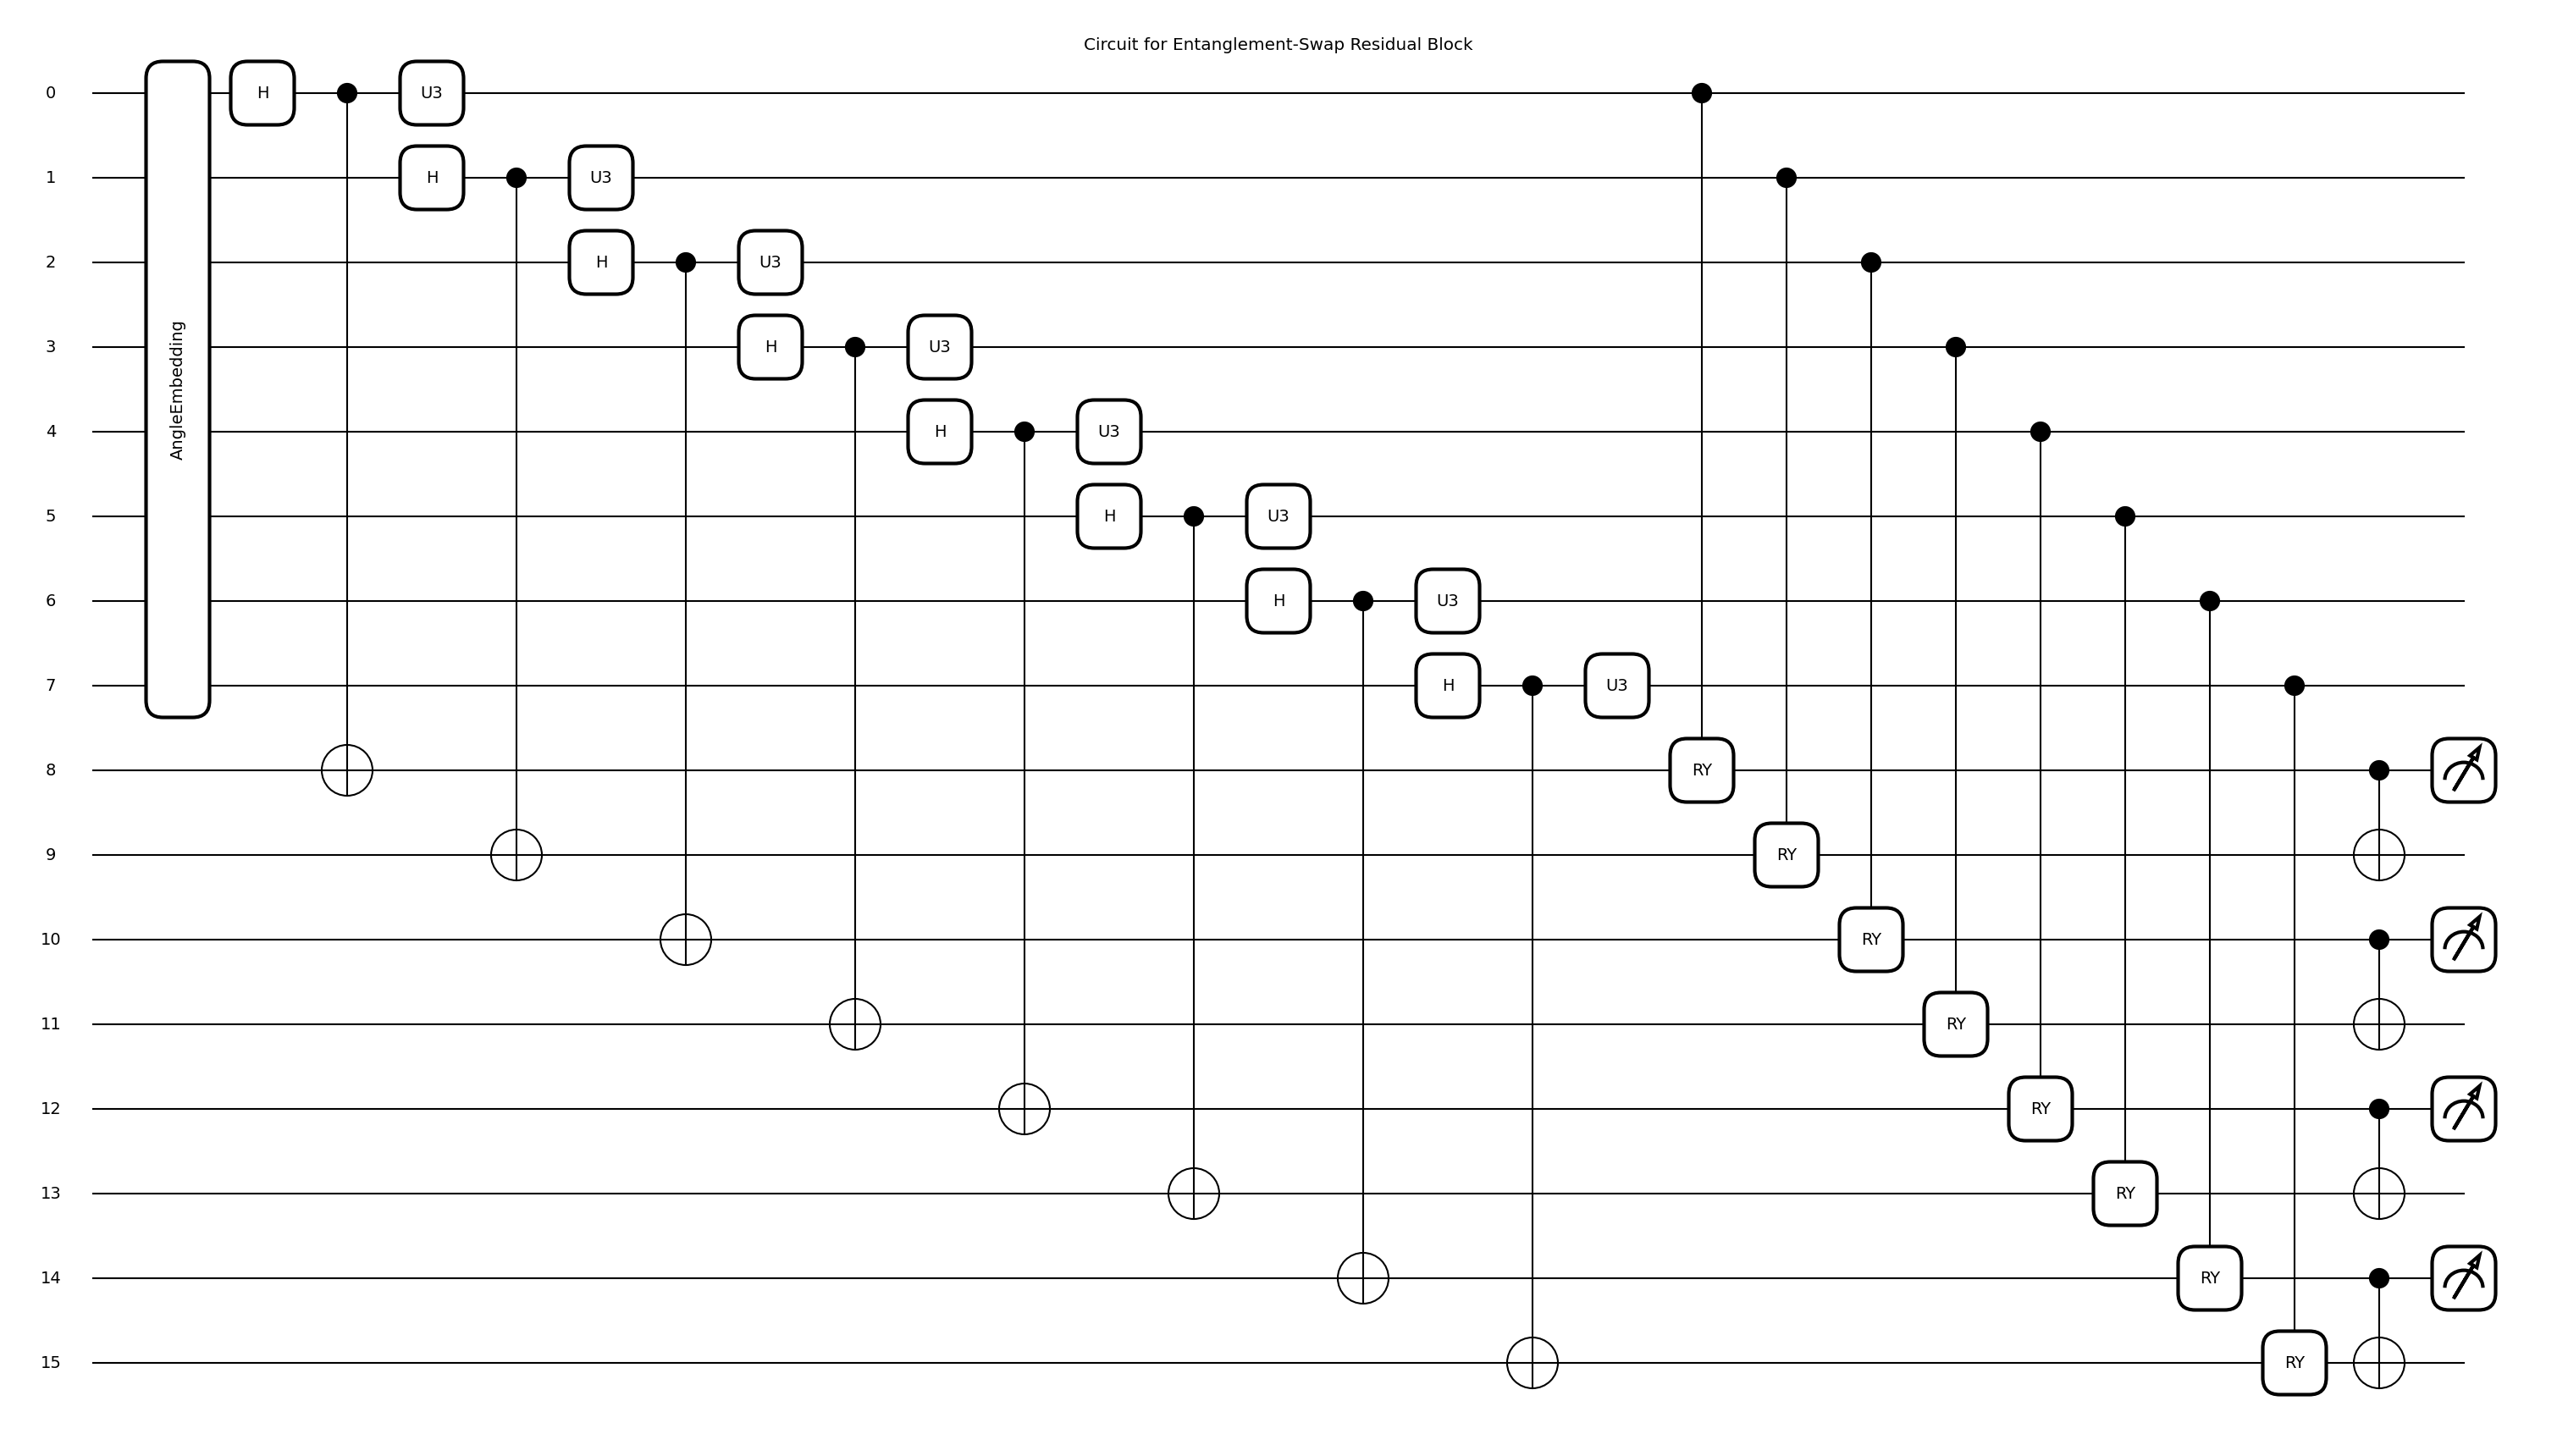

In [53]:
import matplotlib.pyplot as plt

print("Generating visualization for the Entanglement-Swap Residual model (one layer)...")

# We visualize a single layer manually to show the concept
n_vis_qubits = 8
dev_vis = qml.device("default.qubit", wires=2 * n_vis_qubits)

@qml.qnode(dev_vis)
def vis_entanglement_swap_layer(features, conv_params, pool_params, swap_angle):
    data_wires = list(range(n_vis_qubits))
    resid_wires = list(range(n_vis_qubits, 2 * n_vis_qubits))

    qml.AngleEmbedding(features, wires=data_wires, rotation='Y')
    for d, r in zip(data_wires, resid_wires):
        qml.Hadamard(wires=d)
        qml.CNOT(wires=[d, r])

    # Using a dummy convolution for visualization
    for wire in data_wires: qml.U3(*conv_params[wire], wires=wire)

    for d, r in zip(data_wires, resid_wires):
        qml.CRY(swap_angle, wires=[d, r])

    # Using a dummy pooling for visualization
    for i in range(0, len(resid_wires), 2): qml.CNOT(wires=[resid_wires[i], resid_wires[i+1]])
    
    return [qml.expval(qml.PauliZ(w)) for w in resid_wires[::2]]

# Dummy parameters for visualization
dummy_features = torch.randn(n_vis_qubits)
dummy_conv = torch.randn(n_vis_qubits, 3)
dummy_swap = torch.randn(1)

fig, ax = qml.draw_mpl(vis_entanglement_swap_layer)(dummy_features, dummy_conv, None, dummy_swap)
fig.suptitle("Circuit for Entanglement-Swap Residual Block", fontsize="x-large")
plt.show()

In [54]:
def EntanglementResid_Experiment_run(n_qubits, circuit_depth, input_dim, kernel_size, num_epochs=10):
    print("Running on ", device)
    
    model = QTCN_Entanglement_Resid(n_qubits, circuit_depth, input_dim, kernel_size).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)

    # --- Training and Evaluation Loop ---
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"\nFinal Test Results for Model with Entanglement-Swap Residual:")
    print(f"Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}")
    
    return test_loss, test_auc

# --- Execute the experiment ---
print("\n--- Starting Experiment 9: Model with Entanglement-Swap Residual ---")
EntanglementResid_Experiment_run(
    n_qubits=8,
    circuit_depth=3,
    input_dim=input_dim,
    kernel_size=6,
    num_epochs=10
)


--- Starting Experiment 9: Model with Entanglement-Swap Residual ---
Running on  cuda


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch: 01 | Time: 1m 10s
Train Loss: 0.6925, AUC: 0.5899 | Validation Loss: 0.6932, AUC: 0.6030


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Epoch: 02 | Time: 1m 10s
Train Loss: 0.6894, AUC: 0.6340 | Validation Loss: 0.6931, AUC: 0.5969


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch: 03 | Time: 1m 9s
Train Loss: 0.6866, AUC: 0.6570 | Validation Loss: 0.6923, AUC: 0.6064


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch: 04 | Time: 1m 9s
Train Loss: 0.6844, AUC: 0.6672 | Validation Loss: 0.6917, AUC: 0.6097


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch: 05 | Time: 1m 9s
Train Loss: 0.6822, AUC: 0.6784 | Validation Loss: 0.6906, AUC: 0.6235


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Epoch: 06 | Time: 1m 10s
Train Loss: 0.6799, AUC: 0.6805 | Validation Loss: 0.6896, AUC: 0.6280


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch: 07 | Time: 1m 10s
Train Loss: 0.6777, AUC: 0.6926 | Validation Loss: 0.6881, AUC: 0.6437


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


Epoch: 08 | Time: 1m 12s
Train Loss: 0.6757, AUC: 0.6979 | Validation Loss: 0.6870, AUC: 0.6473


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Epoch: 09 | Time: 1m 14s
Train Loss: 0.6731, AUC: 0.7071 | Validation Loss: 0.6858, AUC: 0.6542


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Epoch: 10 | Time: 1m 13s
Train Loss: 0.6710, AUC: 0.7156 | Validation Loss: 0.6840, AUC: 0.6691


100%|██████████| 11/11 [00:07<00:00,  1.54it/s]


Final Test Results for Model with Entanglement-Swap Residual:
Test Loss: 0.6735, Test AUC: 0.7222


(0.6735385710542853, 0.7221783741120757)

### QTCN with quantum residual block: Gated Quantum Residual Connection (Gemini)

This method draws inspiration from classical gated architectures like LSTMs and GRUs. Instead of a simple addition, we'll use a quantum circuit to learn a gating mechanism that dynamically decides how much of the old state to forget and how much of the new, transformed state to incorporate.

How it Works
1. Ancilla as a Gate: We use an ancilla qubit, but instead of controlling the application of the convolution, it will control the mixing of states.

2. Parallel States: We run two operations in parallel. The identity (no operation) is path one. The convolution (F) is applied to a copy of the state, creating path two.

3. Quantum Gating Unit: A small, learnable circuit (our gate) is applied to the ancilla qubit. The state of this ancilla now represents a learned "gate" value.

4. Controlled-SWAP Mixing: We use a qml.CSWAP operation. The ancilla qubit is the control. The target wires are the qubits from the identity path and the qubits from the convolution path. The CSWAP operation performs a SWAP between the two paths, conditional on the state of the gate (ancilla). Because the ancilla is in a superposition, this results in a partial swap, effectively creating a new state that is a learnable, linear combination of the identity and the transformed states: gate * F(x) + (1 - gate) * x.

5. Uncompute and Pool: We discard the transformed path qubits and uncompute the ancilla, leaving the main data qubits in their new "gated" state for the pooling layer.

In [56]:
class QTCN_Gated_Resid(nn.Module):
    """
    Implements a residual connection using a learnable quantum gate.
    (Corrected for SyntaxError)
    """
    def __init__(self, n_qubits, circuit_depth, input_dim, kernel_size):
        super(QTCN_Gated_Resid, self).__init__()
        self.n_main_qubits = n_qubits
        self.circuit_depth = circuit_depth
        
        # Quantum Parameters
        self.conv_params = nn.Parameter(torch.randn(circuit_depth, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))
        # Learnable parameters for the gating unit, 2 for each layer
        self.gate_params = nn.Parameter(torch.randn(circuit_depth, 2))
        
        # Classical components
        self.input_channels = input_dim[1]
        self.kernel_size = kernel_size
        self.fc = nn.Linear(self.input_channels * self.kernel_size, n_qubits)

    def _quantum_gating_unit(self, params, wire):
        """ A small learnable circuit to act as the gate. """
        qml.RY(params[0], wires=wire)
        qml.RZ(params[1], wires=wire)

    def circuit(self, features):
        pass # Logic is in the forward pass

    def forward(self, x):
        batch_size, _, time_steps = x.size()
        
        output_from_windows = []
        for i in range(time_steps - self.kernel_size + 1):
            window = x[:, :, i : i + self.kernel_size].reshape(batch_size, -1)
            reduced_window = self.fc(window)
            
            current_features = reduced_window
            
            for layer in range(self.circuit_depth):
                n_current_qubits = current_features.shape[1]
                # We need 2 sets of main qubits + 1 ancilla
                dev = qml.device("default.qubit", wires=2 * n_current_qubits + 1)
                ancilla_wire = 2 * n_current_qubits

                @qml.qnode(dev, interface="torch")
                def quantum_layer(layer_features, conv_p, pool_p, gate_p):
                    identity_wires = list(range(n_current_qubits))
                    transform_wires = list(range(n_current_qubits, 2 * n_current_qubits))
                    
                    qml.AngleEmbedding(layer_features, wires=identity_wires, rotation='Y')
                    qml.AngleEmbedding(layer_features, wires=transform_wires, rotation='Y')
                    
                    self._apply_convolution(conv_p, transform_wires)
                    self._quantum_gating_unit(gate_p, ancilla_wire)
                    
                    for id_w, tr_w in zip(identity_wires, transform_wires):
                        qml.CSWAP(wires=[ancilla_wire, id_w, tr_w])
                    
                    qml.adjoint(self._quantum_gating_unit)(gate_p, ancilla_wire)
                    self._apply_pooling(pool_p, identity_wires)
                    
                    remaining_wires = identity_wires[::2]
                    return [qml.expval(qml.PauliZ(w)) for w in remaining_wires]

                new_features_list = quantum_layer(
                    current_features,
                    self.conv_params[layer][:n_current_qubits],
                    self.pool_params[layer][:n_current_qubits//2],
                    self.gate_params[layer]
                )
                current_features = torch.stack(new_features_list, dim=1)
                
            output_from_windows.append(current_features.squeeze(-1))
            
        output = torch.mean(torch.stack(output_from_windows, dim=1), dim=1)
        return output

    def _apply_convolution(self, weights, wires):
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    # --- THIS BLOCK IS NOW CORRECTED ---
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])
                    # ------------------------------------

    def _apply_pooling(self, pool_weights, wires):
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

Generating visualization for the Gated Quantum Residual model (Corrected)...


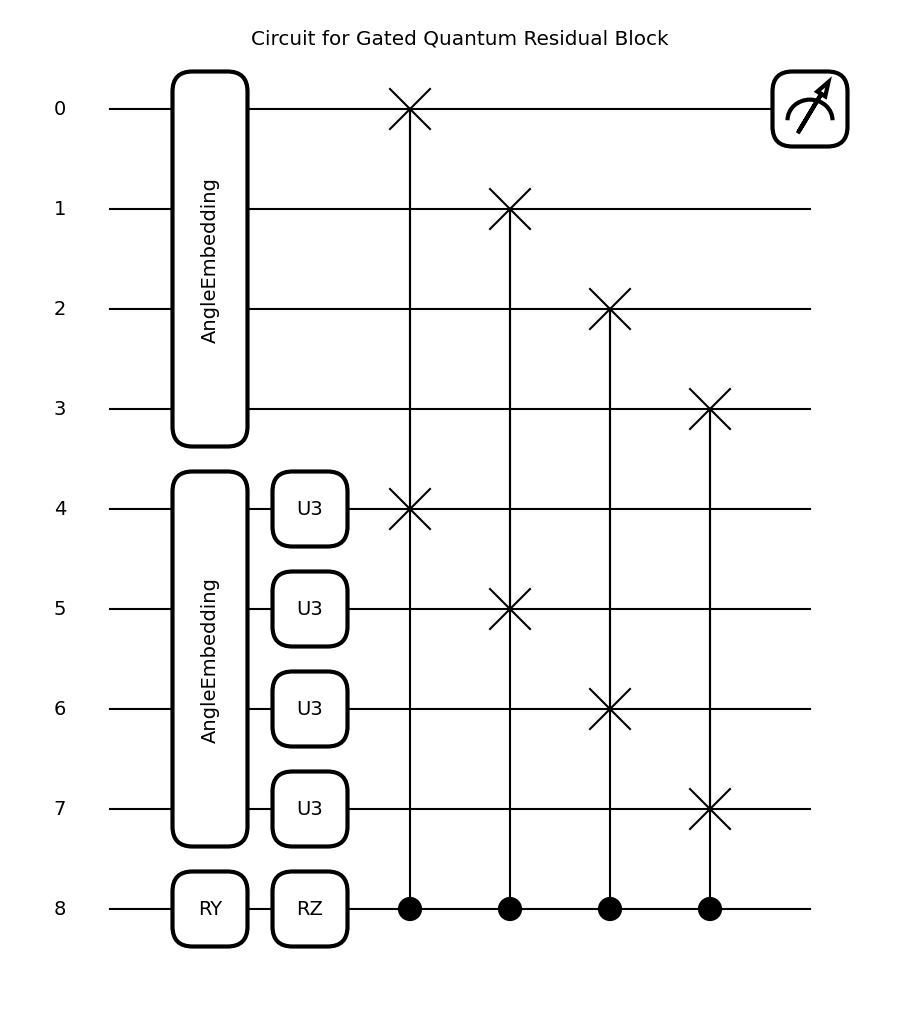

In [58]:
import matplotlib.pyplot as plt

print("Generating visualization for the Gated Quantum Residual model (Corrected)...")

n_vis_qubits = 4 # smaller for clarity
dev_vis = qml.device("default.qubit", wires=2 * n_vis_qubits + 1)
ancilla_vis = 2 * n_vis_qubits

@qml.qnode(dev_vis)
def vis_gated_layer(features, conv_params, gate_params):
    identity_wires = list(range(n_vis_qubits))
    transform_wires = list(range(n_vis_qubits, 2 * n_vis_qubits))
    
    qml.AngleEmbedding(features, wires=identity_wires, rotation='Y')
    qml.AngleEmbedding(features, wires=transform_wires, rotation='Y')
    
    # --- THIS LOOP IS NOW CORRECTED ---
    # We use enumerate to get both the index (for params) and the wire value
    for idx, wire in enumerate(transform_wires):
        qml.U3(*conv_params[idx], wires=wire)
    # ------------------------------------
    
    # Gating unit
    qml.RY(gate_params[0], wires=ancilla_vis)
    qml.RZ(gate_params[1], wires=ancilla_vis)

    for id_w, tr_w in zip(identity_wires, transform_wires):
        qml.CSWAP(wires=[ancilla_vis, id_w, tr_w])
        
    return qml.expval(qml.PauliZ(0))

# Dummy parameters for visualization - these are correct
dummy_features = torch.randn(n_vis_qubits)
dummy_conv = torch.randn(n_vis_qubits, 3)
dummy_gate = torch.randn(2)

fig, ax = qml.draw_mpl(vis_gated_layer)(dummy_features, dummy_conv, dummy_gate)
fig.suptitle("Circuit for Gated Quantum Residual Block", fontsize="x-large")
plt.show()

In [59]:
def GatedResid_Experiment_run(n_qubits, circuit_depth, input_dim, kernel_size, num_epochs=10):
    print("Running on ", device)
    
    model = QTCN_Gated_Resid(n_qubits, circuit_depth, input_dim, kernel_size).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)

    # --- Training and Evaluation Loop ---
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"\nFinal Test Results for Model with Gated Quantum Residual:")
    print(f"Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}")
    
    return test_loss, test_auc

# --- Execute the experiment ---
print("\n--- Starting Experiment 10: Model with Gated Quantum Residual ---")
GatedResid_Experiment_run(
    n_qubits=8,
    circuit_depth=3,
    input_dim=input_dim,
    kernel_size=6,
    num_epochs=10
)


--- Starting Experiment 10: Model with Gated Quantum Residual ---
Running on  cuda


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch: 01 | Time: 1m 35s
Train Loss: 0.7728, AUC: 0.5021 | Validation Loss: 0.7705, AUC: 0.5486


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch: 02 | Time: 1m 35s
Train Loss: 0.7627, AUC: 0.5184 | Validation Loss: 0.7621, AUC: 0.5563


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch: 03 | Time: 1m 34s
Train Loss: 0.7527, AUC: 0.5077 | Validation Loss: 0.7510, AUC: 0.5663


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Epoch: 04 | Time: 1m 38s
Train Loss: 0.7432, AUC: 0.5284 | Validation Loss: 0.7399, AUC: 0.5815


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


Epoch: 05 | Time: 1m 41s
Train Loss: 0.7333, AUC: 0.5084 | Validation Loss: 0.7288, AUC: 0.5968


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


Epoch: 06 | Time: 1m 41s
Train Loss: 0.7231, AUC: 0.5485 | Validation Loss: 0.7195, AUC: 0.5987


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


Epoch: 07 | Time: 1m 38s
Train Loss: 0.7143, AUC: 0.5259 | Validation Loss: 0.7112, AUC: 0.6049


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch: 08 | Time: 1m 35s
Train Loss: 0.7082, AUC: 0.5648 | Validation Loss: 0.7059, AUC: 0.6112


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch: 09 | Time: 1m 34s
Train Loss: 0.7029, AUC: 0.5747 | Validation Loss: 0.7017, AUC: 0.6183


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch: 10 | Time: 1m 34s
Train Loss: 0.7002, AUC: 0.5812 | Validation Loss: 0.6987, AUC: 0.6239


100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


Final Test Results for Model with Gated Quantum Residual:
Test Loss: 0.7079, Test AUC: 0.5673


(0.7078792777928439, 0.5672849250197316)